#### Generating Synthetic Energy Data using Generative Modelling


### 0. Imports

In [128]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import os
from scipy.stats import ks_2samp, chisquare, skew, kurtosis, wasserstein_distance
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from torch.nn import Linear, Module, Parameter, ReLU
from collections import namedtuple
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from rdt.transformers import ClusterBasedNormalizer, OneHotEncoder
import contextlib
from torch.nn.functional import cross_entropy


### 1. Data Preprocessing

In [17]:
path = "/data/home/jayadeeps/eda/eda_dataset/electricity/1.csv"
df = pd.read_csv(path)

/tmp/ipykernel_38087/1981449183.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [18]:
df.head()

,timestamp,W,VAR,VA,f,VLN,PF,A
0,1369353600,0.0,0.0,0.0,49.997299,232.326004,0.0,0.0
1,1369353601,0.0,0.0,0.0,49.9949,232.326004,0.0,0.0
2,1369353602,0.0,0.0,0.0,49.9949,232.326004,0.0,0.0
3,1369353603,0.0,0.0,0.0,49.993099,232.311005,0.0,0.0
4,1369353604,0.0,0.0,0.0,49.991501,232.292999,0.0,0.0


In [19]:
df.dtypes

timestamp     int64
W            object
VAR          object
VA           object
f            object
VLN          object
PF           object
A            object
dtype: object

In [20]:
# Converting the columns to float
df[['W', 'VAR', 'VA', 'f', 'VLN', 'PF', 'A']] = df[['W', 'VAR', 'VA', 'f', 'VLN', 'PF', 'A']].apply(pd.to_numeric, errors='coerce')


In [24]:
# all column datatype converted to float 
df.dtypes

timestamp      int64
W            float64
VAR          float64
VA           float64
f            float64
VLN          float64
PF           float64
A            float64
dtype: object

In [25]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 timestamp     0
W            20
VAR          24
VA           18
f            15
VLN          14
PF           25
A            42
dtype: int64


In [28]:
df = df.dropna()

In [30]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 timestamp    0
W            0
VAR          0
VA           0
f            0
VLN          0
PF           0
A            0
dtype: int64


In [29]:
df.shape

(4391017, 8)

In [31]:
df.describe()

,timestamp,W,VAR,VA,f,VLN,PF,A
count,4.391017e+06,4.391017e+06,4.391017e+06,4.391017e+06,4.391017e+06,4.391017e+06,4.391017e+06,4.391017e+06
mean,1.372467e+09,2.188133e+02,1.757562e+01,2.346428e+02,5.007154e+01,2.325001e+02,5.327040e-01,1.067745e+00
std,1.865670e+06,5.965363e+02,7.174893e+01,6.028375e+02,1.466854e-01,1.271231e+01,2.717959e-01,2.776034e+00
min,1.369354e+09,0.000000e+00,-1.129120e+02,0.000000e+00,0.000000e+00,0.000000e+00,-9.990000e-01,0.000000e+00
25%,1.370861e+09,1.481370e+01,6.000030e-18,2.747580e+01,4.997960e+01,2.263700e+02,5.031760e-01,1.172510e-01
50%,1.372463e+09,1.542100e+01,6.000030e-18,2.931250e+01,5.006600e+01,2.345650e+02,5.348970e-01,1.250970e-01
75%,1.374084e+09,1.664250e+01,6.000030e-18,3.193660e+01,5.016440e+01,2.412140e+02,5.620460e-01,1.361560e-01
max,1.375717e+09,4.233190e+03,1.219060e+03,4.248360e+03,5.076670e+01,2.668220e+02,9.999990e-01,1.905530e+01


##### Visualizing Modes in the data 

In [40]:
def estimate_modes_and_fit_gmm(df, max_components=5):
    gmm_models = {}
    modes = {}
    
    for column in df.columns:
        data = df[column].dropna().values.reshape(-1, 1)  
        
        best_bic = np.inf  
        best_gmm = None
        best_n_components = 0
        
        for n_components in range(1, max_components + 1):
            gmm = GaussianMixture(n_components=n_components, random_state=42)
            gmm.fit(data)
            
            bic = gmm.bic(data)
            if bic < best_bic:
                best_bic = bic
                best_gmm = gmm
                best_n_components = n_components
        
        gmm_models[column] = best_gmm
        modes[column] = best_n_components
        
        print(f"Column: {column} -> Estimated Modes: {best_n_components}")
    
    return gmm_models, modes

def visualize_gmm_results(df, gmm_models, modes): 
    plt.figure(figsize=(15, 10))
    
    for idx, column in enumerate(df.columns, start=1):
        data = df[column].dropna().values.reshape(-1, 1)
        gmm = gmm_models[column]
        
        plt.subplot(3, 3, idx)  
        plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')
        
        x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
        log_prob = gmm.score_samples(x)
        pdf = np.exp(log_prob)
        plt.plot(x, pdf, label=f'VGM Fit (n_components={modes[column]})', color='b')
        
        means = gmm.means_.flatten()
        for mean in means:
            plt.axvline(mean, color='r', linestyle='--', label=f'Mode at {mean:.2f}')
        
        plt.title(f'VGM Fit for Column: {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Density')
        plt.legend(loc='upper right')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Column: timestamp -> Estimated Modes: 5
Column: W -> Estimated Modes: 5
Column: VAR -> Estimated Modes: 5
Column: VA -> Estimated Modes: 5
Column: f -> Estimated Modes: 2
Column: VLN -> Estimated Modes: 4
Column: PF -> Estimated Modes: 5
Column: A -> Estimated Modes: 5


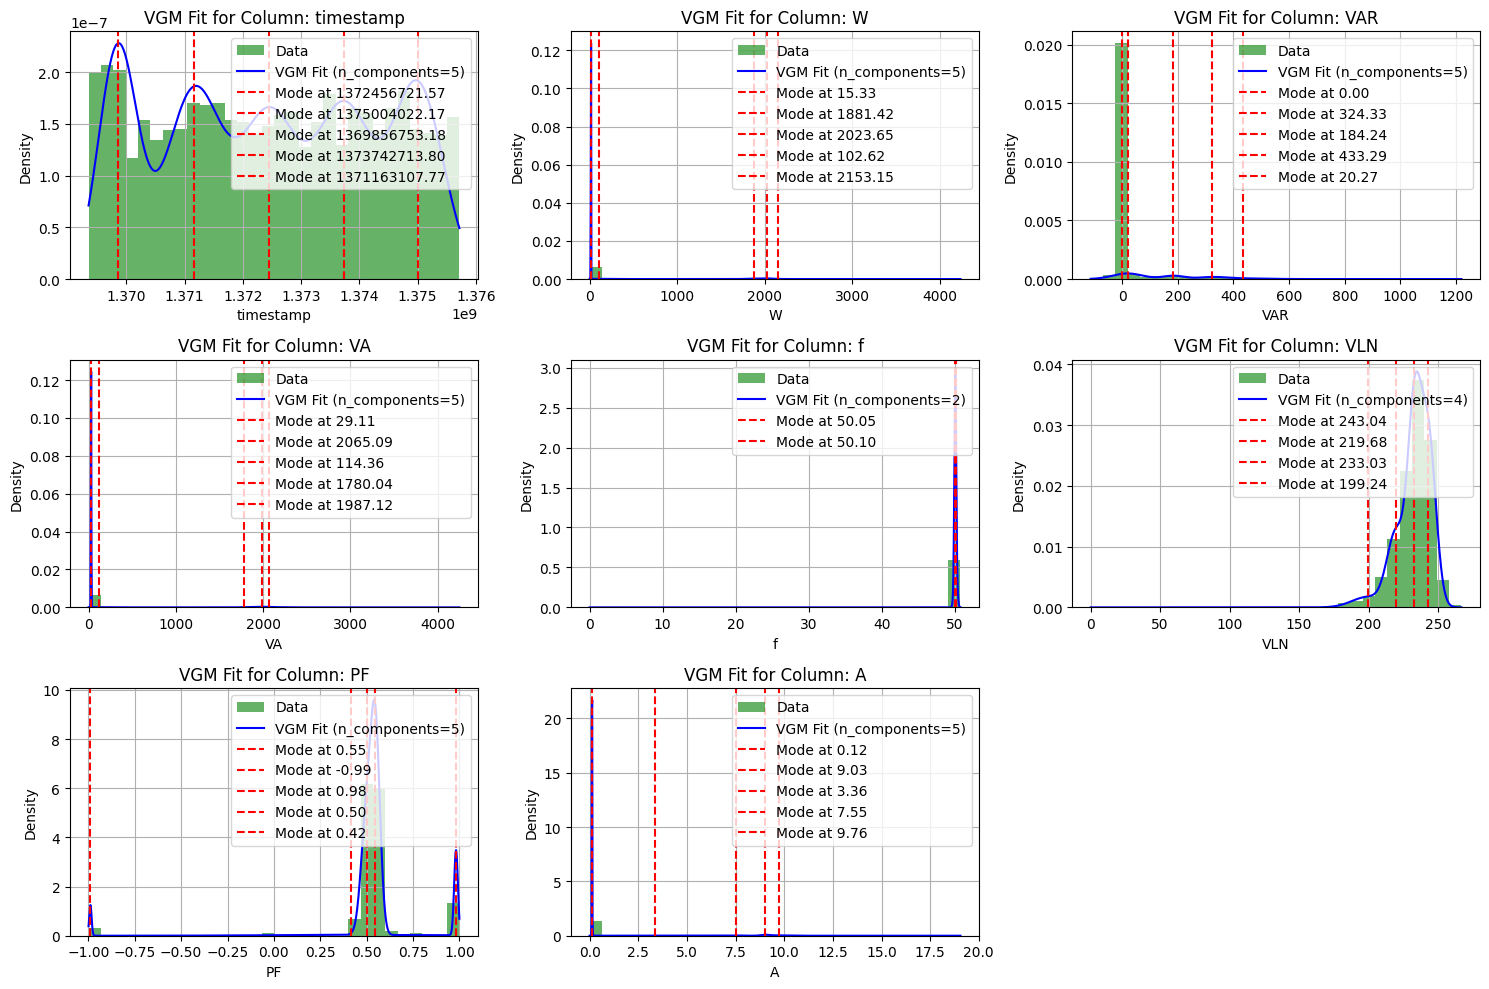

In [41]:
# gmm_models, modes = estimate_modes_and_fit_gmm(df, max_components=5)
# visualize_gmm_results(df, gmm_models, modes)

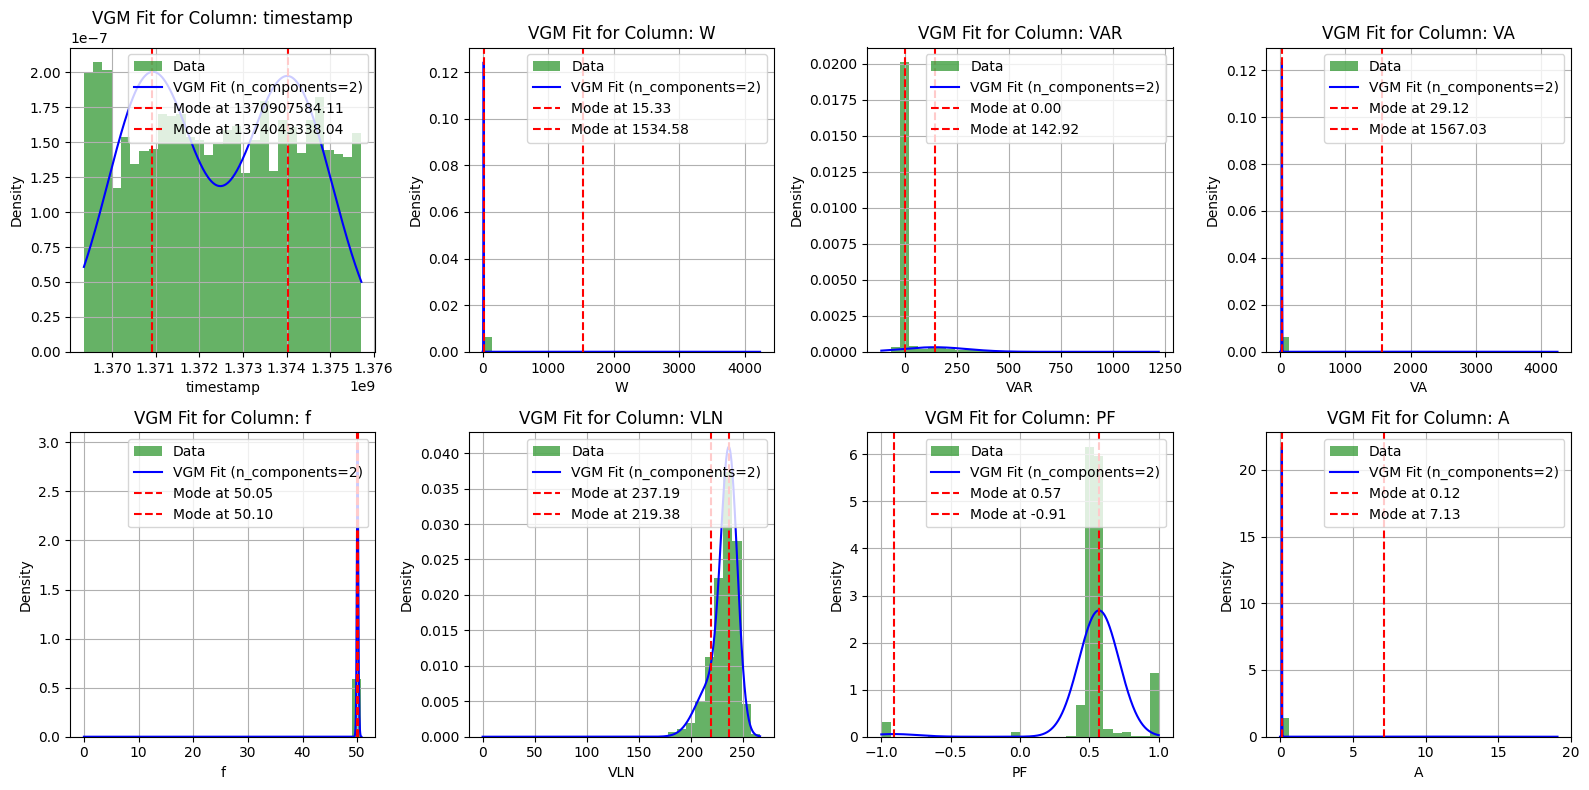

In [38]:
# visualize_with_vgm(df, n_components=2)

In [74]:
# df = df.drop(columns = ['timestamp'])
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled.to_csv("cleaned_data.csv",index = False)

In [47]:
df_scaled

,W,VAR,VA,f,VLN,PF,A
0,-0.366806,-0.24496,-0.389231,-0.506122,-0.013694,-1.959942,-0.384630
1,-0.366806,-0.24496,-0.389231,-0.522479,-0.013694,-1.959942,-0.384630
2,-0.366806,-0.24496,-0.389231,-0.522479,-0.013694,-1.959942,-0.384630
3,-0.366806,-0.24496,-0.389231,-0.534754,-0.014874,-1.959942,-0.384630
4,-0.366806,-0.24496,-0.389231,-0.545651,-0.016290,-1.959942,-0.384630
...,...,...,...,...,...,...,...
4391012,-0.341829,-0.24496,-0.344884,0.565558,0.740457,0.090671,-0.344836
4391013,-0.341829,-0.24496,-0.344884,0.565558,0.740457,0.090671,-0.344836
4391014,-0.341823,-0.24496,-0.344919,0.578509,0.742030,0.092775,-0.344870
4391015,-0.341754,-0.24496,-0.344848,0.602383,0.746672,0.095160,-0.344817


In [70]:
#Split the data: 70% train, 15% validation, 15% test
train_data, temp_data = train_test_split(df_scaled, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [71]:
# Save the data
train_data.to_csv("train_data.csv", index = False)
val_data.to_csv("val_data.csv", index = False)
test_data.to_csv("test_data.csv", index = False)

##### Visualizing after Standardizing

Column: W -> Estimated Modes: 5
Column: VAR -> Estimated Modes: 5
Column: VA -> Estimated Modes: 5
Column: f -> Estimated Modes: 2
Column: VLN -> Estimated Modes: 4
Column: PF -> Estimated Modes: 5
Column: A -> Estimated Modes: 5


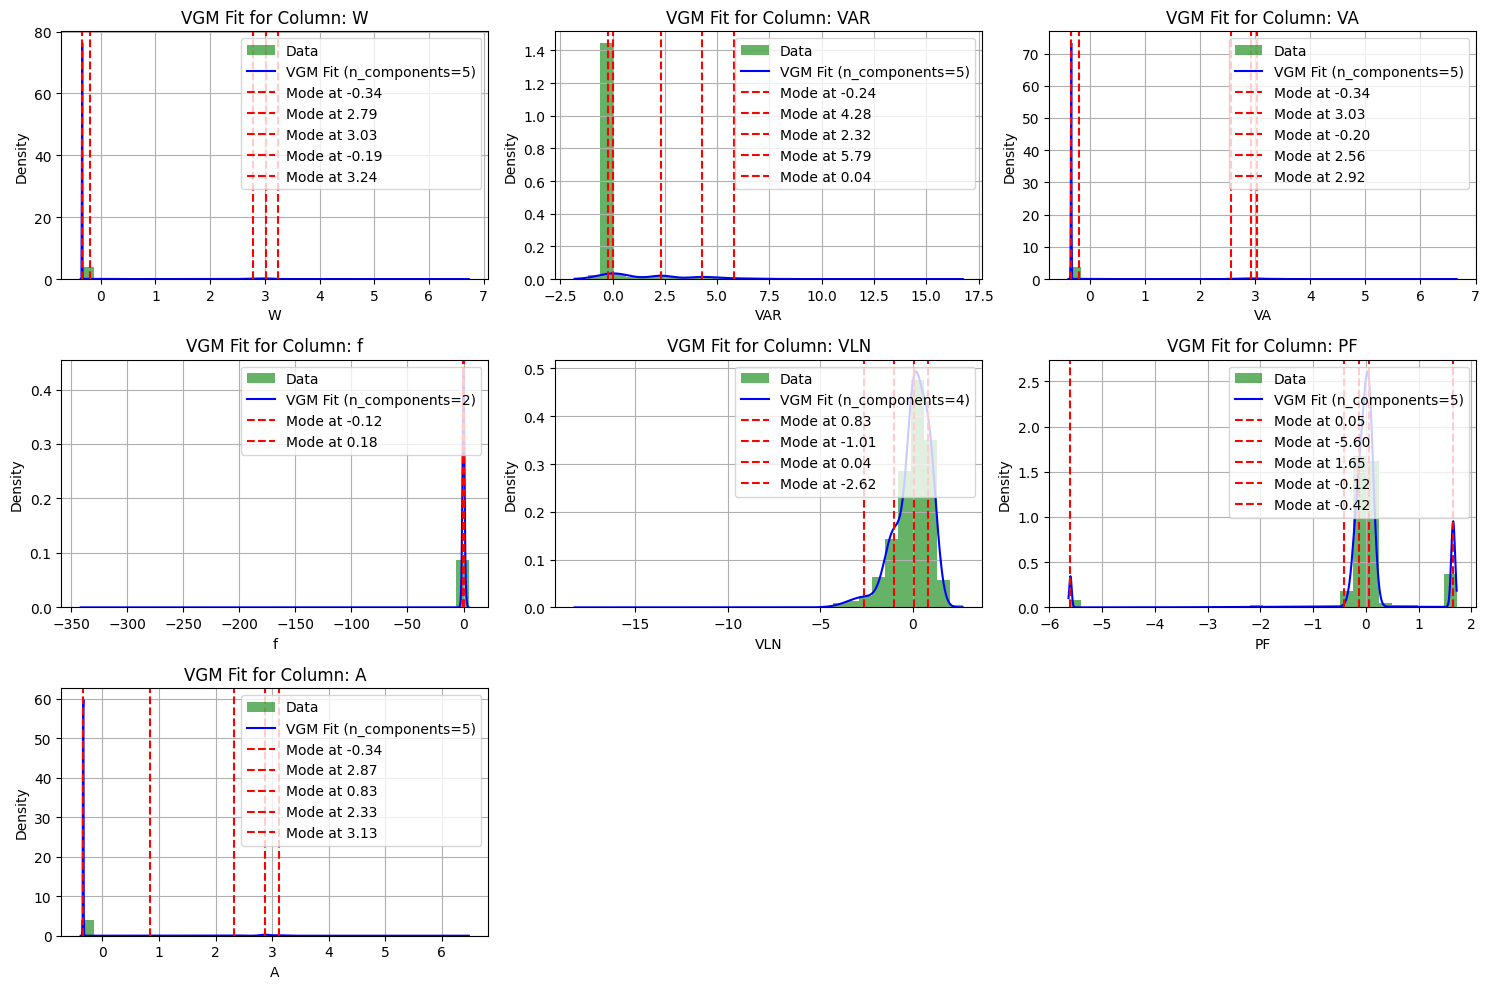

In [73]:
# df_scaled = pd.read_csv("/data/home/jayadeeps/eda/cleaned_data.csv")
gmm_models, modes = estimate_modes_and_fit_gmm(df_scaled, max_components=5)
visualize_gmm_results(df, gmm_models, modes)

### 2. Dataset Class

In [2]:
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = data.values
        # Preprocess and convert data into a PyTorch tensor
        self.processed_data = torch.tensor(self.data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.processed_data)
    
    def __getitem__(self, idx):
        return self.processed_data[idx]

In [3]:
# Create datasets
train_data = pd.read_csv("Datasets/train_data.csv")
val_data = pd.read_csv("Datasets/val_data.csv")
test_data = pd.read_csv("Datasets/test_data.csv")

train_data = TabularDataset(train_data)
val_data = TabularDataset(val_data)
test_data = TabularDataset(test_data)

In [4]:
print(f"Train Data Size: {len(train_data)}")
print(f"Validation Data Size: {len(val_data)}")
print(f"Test Data Size: {len(test_data)}")

Train Data Size: 3073711
Validation Data Size: 658653
Test Data Size: 658653


### 3. GAN Architecture, Training and Inference

#### a. Architechture

In [8]:
class GAN(nn.Module):
    def __init__(self, embedding_dim, output_dim):
        super(GAN, self).__init__()
        self.generator = Generator(embedding_dim, output_dim)
        self.discriminator = Discriminator(output_dim)

    def generate(self, noise):
        return self.generator(noise)

    def discriminate(self, data):
        return self.discriminator(data)

class Generator(nn.Module):
    def __init__(self, embedding_dim, output_dim):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh() 
    
    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self, embedding_dim):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(embedding_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x)) 
       
        return x

In [13]:
emb_dim = 100
op_dim=7
bs = 64

gen = Generator(emb_dim,op_dim)

z = torch.randn(bs, emb_dim)
op = gen(z)
op.shape

torch.Size([64, 7])

In [14]:

disc = Discriminator(op_dim)
dop = disc(op)
dop.shape

torch.Size([64, 1])

#### b. Training

In [ ]:
def train_gan(gan, train_dataset, num_epochs, lr, embedding_dim, device='cuda', log_file='gan_loss_1.txt', k = 2, save_path=None, batch_size = 64):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer_g = optim.Adam(gan.generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()

    gan = gan.to(device)
    
    if not os.path.exists(log_file):
        with open(log_file, 'w') as f:
            f.write('epoch,gen_loss,disc_loss\n')
    
    for epoch in range(num_epochs):
        epoch_loss_d = 0.0  
        epoch_loss_g = 0.0  
        
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        
        for i, real_data in enumerate(progress_bar):
            batch_size = real_data.size(0)

            # Labels for real (1) and fake (0) data
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Move real data to device (GPU/CPU)
            real_data = real_data.to(device)

            # ====================
            # Train Discriminator (k times)
            # ====================
            for _ in range(k):
                # Discriminator loss on real data
                outputs_real = gan.discriminator(real_data)
                d_loss_real = criterion(outputs_real, real_labels)

                # Generate fake data
                noise = torch.randn(batch_size, embedding_dim).to(device)
                fake_data = gan.generate(noise)

                # Discriminator loss on fake data
                outputs_fake = gan.discriminate(fake_data.detach())  
                d_loss_fake = criterion(outputs_fake, fake_labels)

                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake

                # Backward pass and optimize discriminator
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

                # Update progress bar and epoch loss
                progress_bar.set_postfix(d_loss=d_loss.item())
                epoch_loss_d += d_loss.item()


            # ====================
            # Train Generator
            # ====================
            noise = torch.randn(batch_size, embedding_dim).to(device)
            fake_data = gan.generate(noise)

            outputs_fake_for_g = gan.discriminate(fake_data)
            g_loss = criterion(outputs_fake_for_g, real_labels)  

            # Backward pass and optimize generator
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            # Update progress bar and epoch loss
            progress_bar.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())
            epoch_loss_d += d_loss.item()
            epoch_loss_g += g_loss.item()

        # Average losses for the epoch
        avg_loss_d = epoch_loss_d / len(train_loader)
        avg_loss_g = epoch_loss_g / len(train_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {avg_loss_d:.4f}, G Loss: {avg_loss_g:.4f}")

        # Log losses to file
        with open(log_file, 'a') as f:
            f.write(f"{epoch+1},{avg_loss_g:.4f},{avg_loss_d:.4f}\n")

         # Save the model every 50 epochs
        if save_path is not None and (epoch + 1) % 50 == 0:
            save_model(gan, save_path, epoch + 1)

def save_model(gan, save_path, epoch):
    # Create a folder for the epoch
    epoch_folder = os.path.join(save_path, f"epoch_{epoch}")
    if not os.path.exists(epoch_folder):
        os.makedirs(epoch_folder)

    # Save the generator and discriminator in that folder
    generator_path = os.path.join(epoch_folder, "generator.pth")
    discriminator_path = os.path.join(epoch_folder, "discriminator.pth")
    
    # Save generator and discriminator
    torch.save(gan.generator, generator_path)
    torch.save(gan.discriminator, discriminator_path)
    
    print(f"Model saved at epoch {epoch} to {save_path}")

In [34]:
# Example usage:
embed_dim = 100
op_dim = 7
n_epochs = 5000
lr = 0.0002
k=2
batch_size = 128
log_file = "/data/home/jayadeeps/eda/Losses/gan_loss_1.txt"
model_save_path = "/data/home/jayadeeps/eda/Models/gan1"

gan = GAN(embedding_dim=embed_dim, output_dim=op_dim)

# Train the GAN
train_gan(gan, train_data, num_epochs=n_epochs, lr=lr, embedding_dim=embed_dim, k=k, device="cuda:4", log_file=log_file, save_path=model_save_path, batch_size = batch_size)

Epoch [1/5000]:   0%|          | 0/24014 [00:00<?, ?it/s]

KeyboardInterrupt: 

Total Training Time :- Oct 21 23:22:29

#### c. Inference

In [105]:

def generate_synthetic_data(gen, num_samples, embedding_dim, device='cpu'):
    gen.eval()
    gen.to(device)
    noise = torch.randn(num_samples, embedding_dim).to(device)
    synthetic_data = gen(noise)
    synthetic_data = synthetic_data.detach().cpu().numpy()
    columns = ['W', 'VAR', 'VA', 'f', 'VLN', 'PF', 'A']
    df = pd.DataFrame(synthetic_data, columns = columns)
    return df

def hist_plot(org_df, syn_df):
    columns = org_df.columns
    num_columns = len(columns)

    nrows = (num_columns + 2) // 3  # Add 2 to round up if num_columns is not a multiple of 3
    ncols = 3
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 15)) 
    axs = axs.flatten()
    '''for i, col in enumerate(columns):
        axs[row, col_idx].hist(org_df[col], bins=50, alpha=0.3, color='orange', label='Original', density = False)
        
        axs[row, col_idx].hist(syn_df[col], bins=50, alpha=0.8, color='green', label='Synthetic', density = False)

        axs[row, col_idx].set_title(col)
        axs[row, col_idx].legend()

    axs[-1, -1].axis('off')
    axs[-1, -2].axis('off')'''
    
    for i, col in enumerate(columns):
        axs[i].hist(org_df[col], bins=50, alpha=0.3, color='orange', label='Original', density=False)
        axs[i].hist(syn_df[col], bins=50, alpha=0.8, color='green', label='Synthetic', density=False)
        axs[i].set_title(col)
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Frequency")
        axs[i].legend()

    # Turn off unused subplots
    for j in range(num_columns, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

def ks_test(org_df, syn_df):
    results = []

    for col in org_df.columns:
        stat, p_value = ks_2samp(org_df[col], syn_df[col])
        results.append({
            'Column': col,
            'K-S Statistic': stat,
            'p-value': p_value
        })

    ks_results_df = pd.DataFrame(results)

    return ks_results_df

def chi_square_test(org_df, syn_df):
    results = []

    for col in org_df.columns:
        original_counts = org_df[col].value_counts()
        synthetic_counts = syn_df[col].value_counts()

        all_values = sorted(set(original_counts.index).union(set(synthetic_counts.index)))

        original_freq = [original_counts.get(val, 0) for val in all_values]
        synthetic_freq = [synthetic_counts.get(val, 0) for val in all_values]

        total_original = sum(original_freq)
        total_synthetic = sum(synthetic_freq)

        if total_original == 0 or total_synthetic == 0:
            continue

        synthetic_freq = [x * total_original / total_synthetic for x in synthetic_freq]

        chi2_stat, p_value = chisquare(synthetic_freq, f_exp=original_freq)

        results.append({'Column': col, 'Chi-Square Statistic': chi2_stat, 'p-value': p_value})

    results_df = pd.DataFrame(results)
    return results_df

def compare_summary_statistics(org_df, syn_df):
    summary_stats = []

    for col in org_df.columns:
        org_mean = org_df[col].mean()
        org_median = org_df[col].median()
        org_std = org_df[col].std()
        org_skew = skew(org_df[col])
        org_kurt = kurtosis(org_df[col])
        org_iqr = org_df[col].quantile(0.75) - org_df[col].quantile(0.25)

        syn_mean = syn_df[col].mean()
        syn_median = syn_df[col].median()
        syn_std = syn_df[col].std()
        syn_skew = skew(syn_df[col])
        syn_kurt = kurtosis(syn_df[col])
        syn_iqr = syn_df[col].quantile(0.75) - syn_df[col].quantile(0.25)

        summary_stats.append({
            'Column': col,
            'Original Mean': org_mean,
            'Synthetic Mean': syn_mean,
            'Original Median': org_median,
            'Synthetic Median': syn_median,
            'Original Std Dev': org_std,
            'Synthetic Std Dev': syn_std,
            'Original Skewness': org_skew,
            'Synthetic Skewness': syn_skew,
            'Original Kurtosis': org_kurt,
            'Synthetic Kurtosis': syn_kurt,
            'Original IQR': org_iqr,
            'Synthetic IQR': syn_iqr
        })

    summary_stats_df = pd.DataFrame(summary_stats)
    return summary_stats_df

def compute_emd(org_df, syn_df):
    emd_results = []

    for col in org_df.columns:
        emd_value = wasserstein_distance(org_df[col], syn_df[col])
        emd_results.append({'Column': col, 'EMD': emd_value})

    emd_results_df = pd.DataFrame(emd_results)
    return emd_results_df


def plot_kde(org_df, syn_df):
    columns = org_df.columns
    num_columns = len(columns)

    fig, axs = plt.subplots(3, (num_columns + 2) // 3, figsize=(20, 15))

    for i, col in enumerate(columns):
        row = i // ((num_columns + 2) // 3)
        col_idx = i % ((num_columns + 2) // 3)

        sns.kdeplot(org_df[col], ax=axs[row, col_idx], color='blue', label='Original', fill=True, alpha=0.5)

        sns.kdeplot(syn_df[col], ax=axs[row, col_idx], color='green', label='Synthetic', fill=True, alpha=0.5)

        axs[row, col_idx].set_title(col)
        axs[row, col_idx].legend()

    for j in range(i + 1, 3 * ((num_columns + 2) // 3)):
        axs[j // ((num_columns + 2) // 3), j % ((num_columns + 2) // 3)].axis('off')

    plt.tight_layout()
    plt.show()
    
    

def plot_losses(file_path):
    # Read the data
    data = pd.read_csv(file_path)
    
    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(data['epoch'], data['gen_loss'], label='Generator Loss', color='blue', marker='o')
    plt.plot(data['epoch'], data['disc_loss'], label='Discriminator Loss', color='red', marker='o')
    
    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

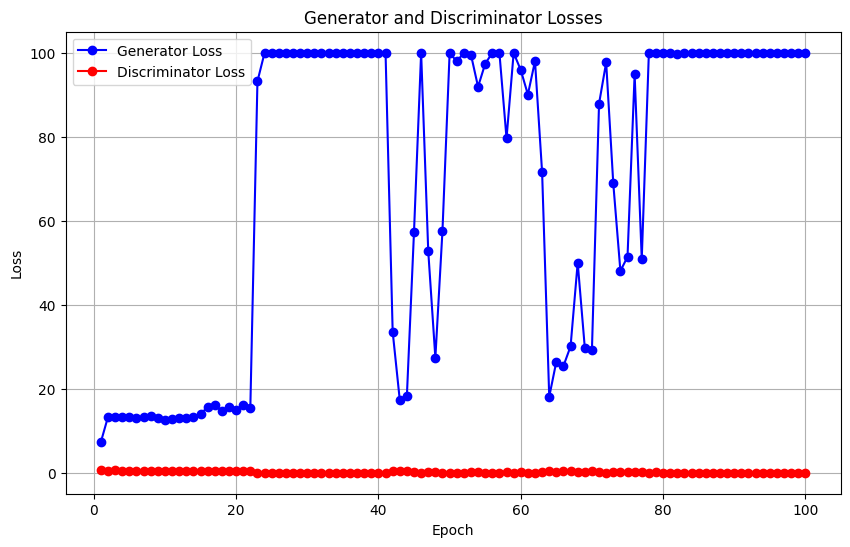

In [108]:
loss_path = "/data/home/jayadeeps/eda/Losses/ctgan_loss_1.txt"
plot_losses(loss_path)

In [9]:
model_path = "/data/home/jayadeeps/eda/Models/gan1/epoch_50/generator.pth"
gen = torch.load(model_path)

num_samples = 600000  
embedding_dim = 100  
syn_df = generate_synthetic_data(gen, num_samples, embedding_dim)
org_df = pd.read_csv("/data/home/jayadeeps/eda/Datasets/test_data.csv")

/tmp/ipykernel_2521283/2716544458.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen = torch.load(model_path)


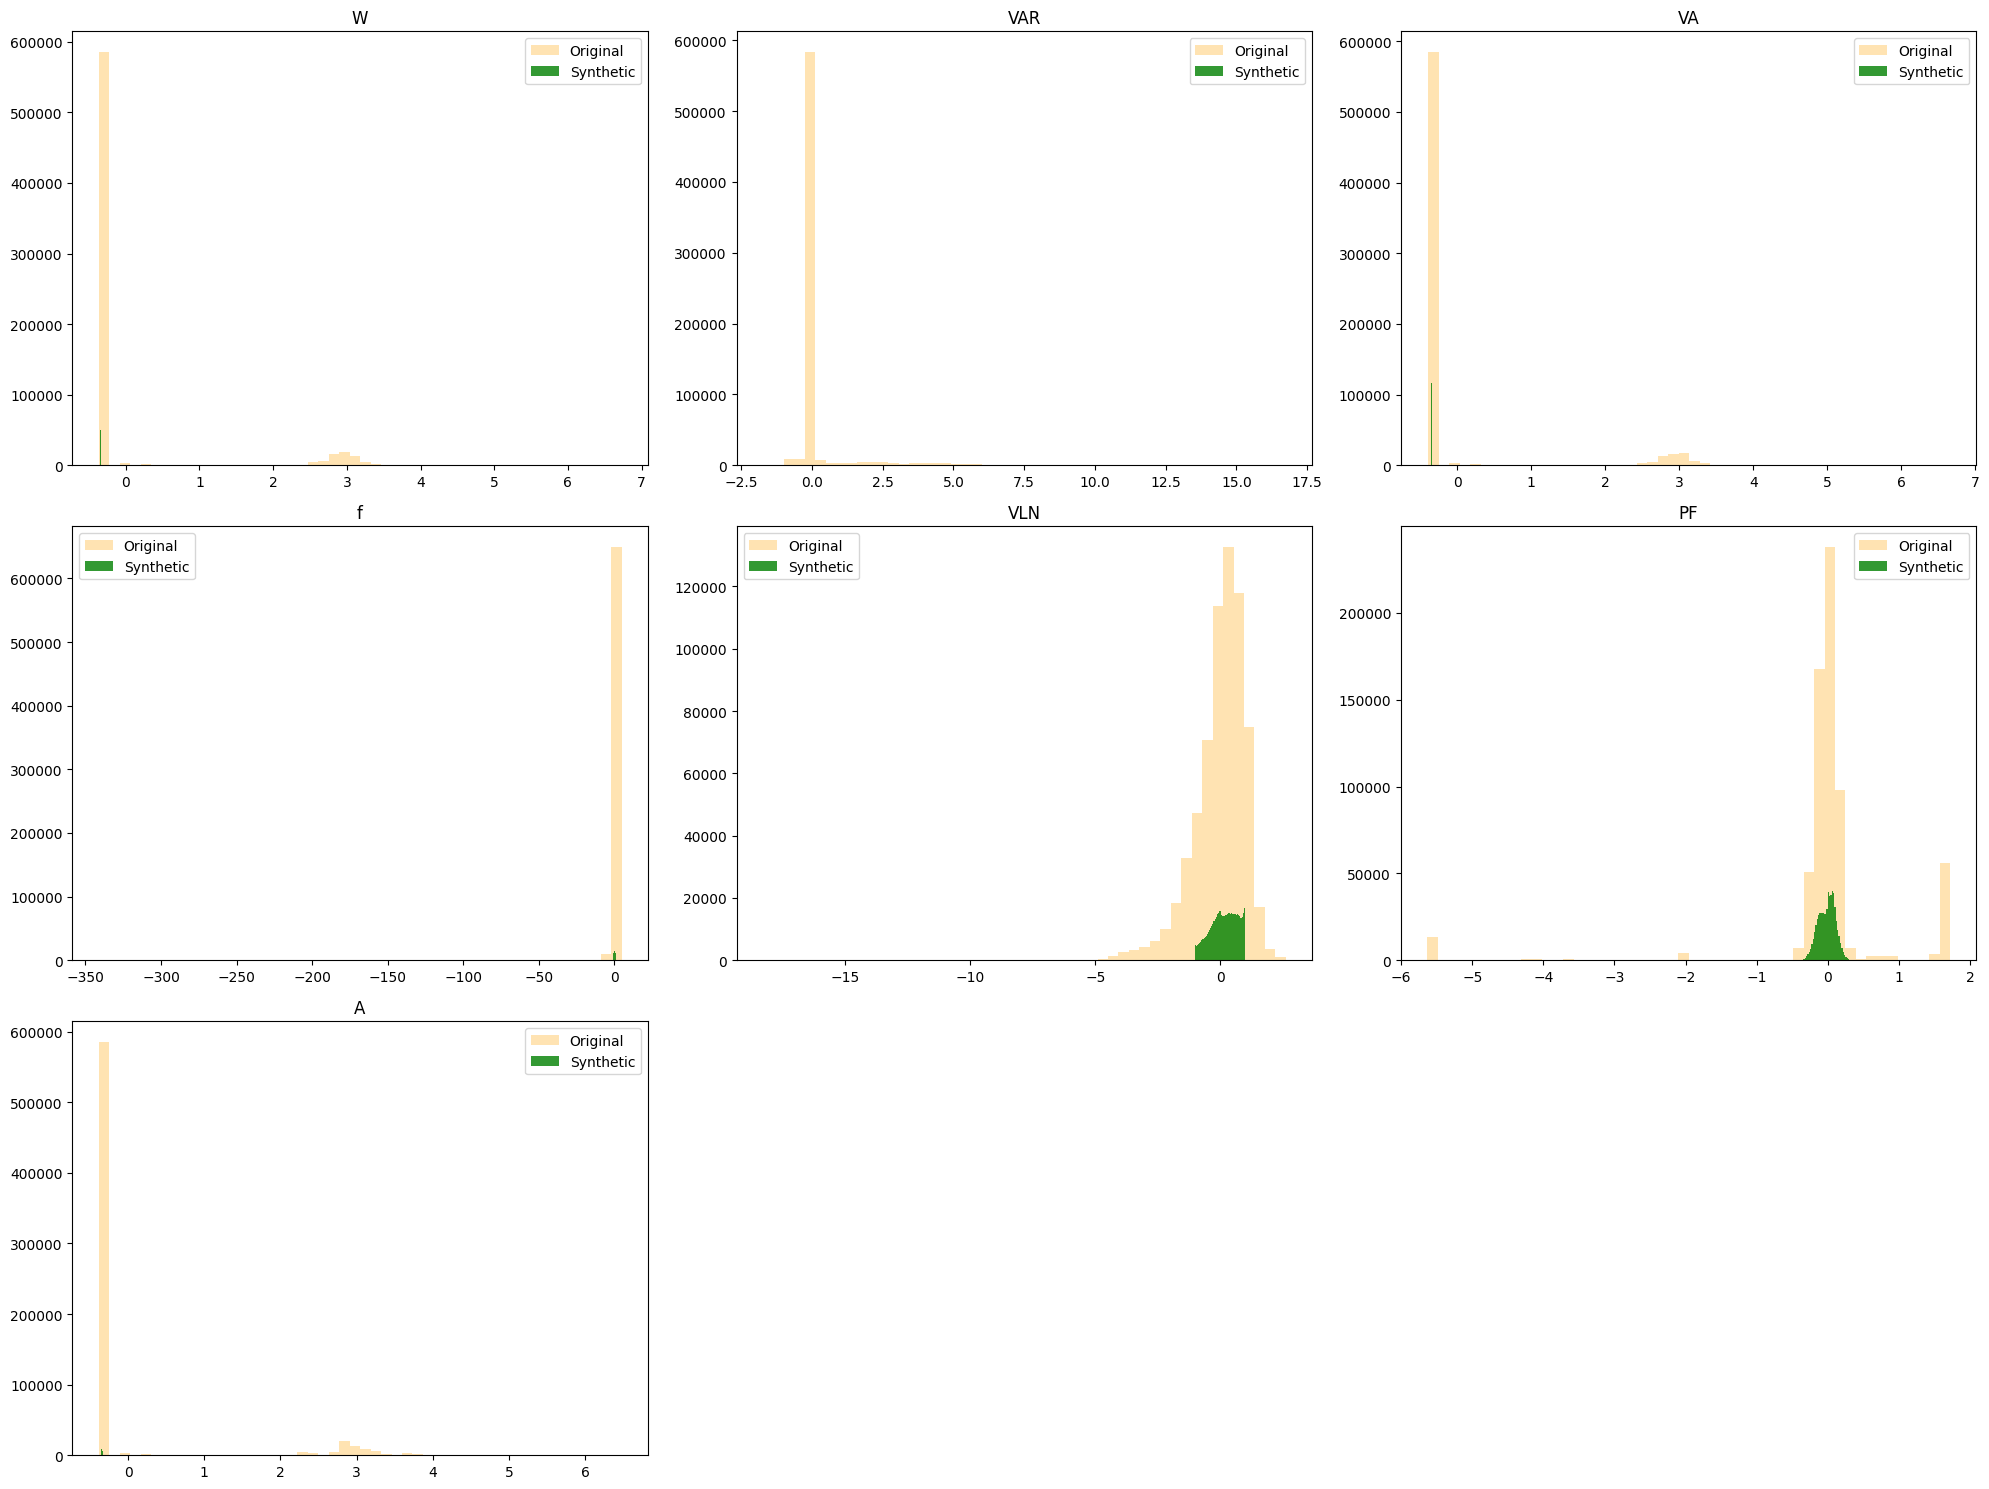

In [83]:
hist_plot(org_df, syn_df)

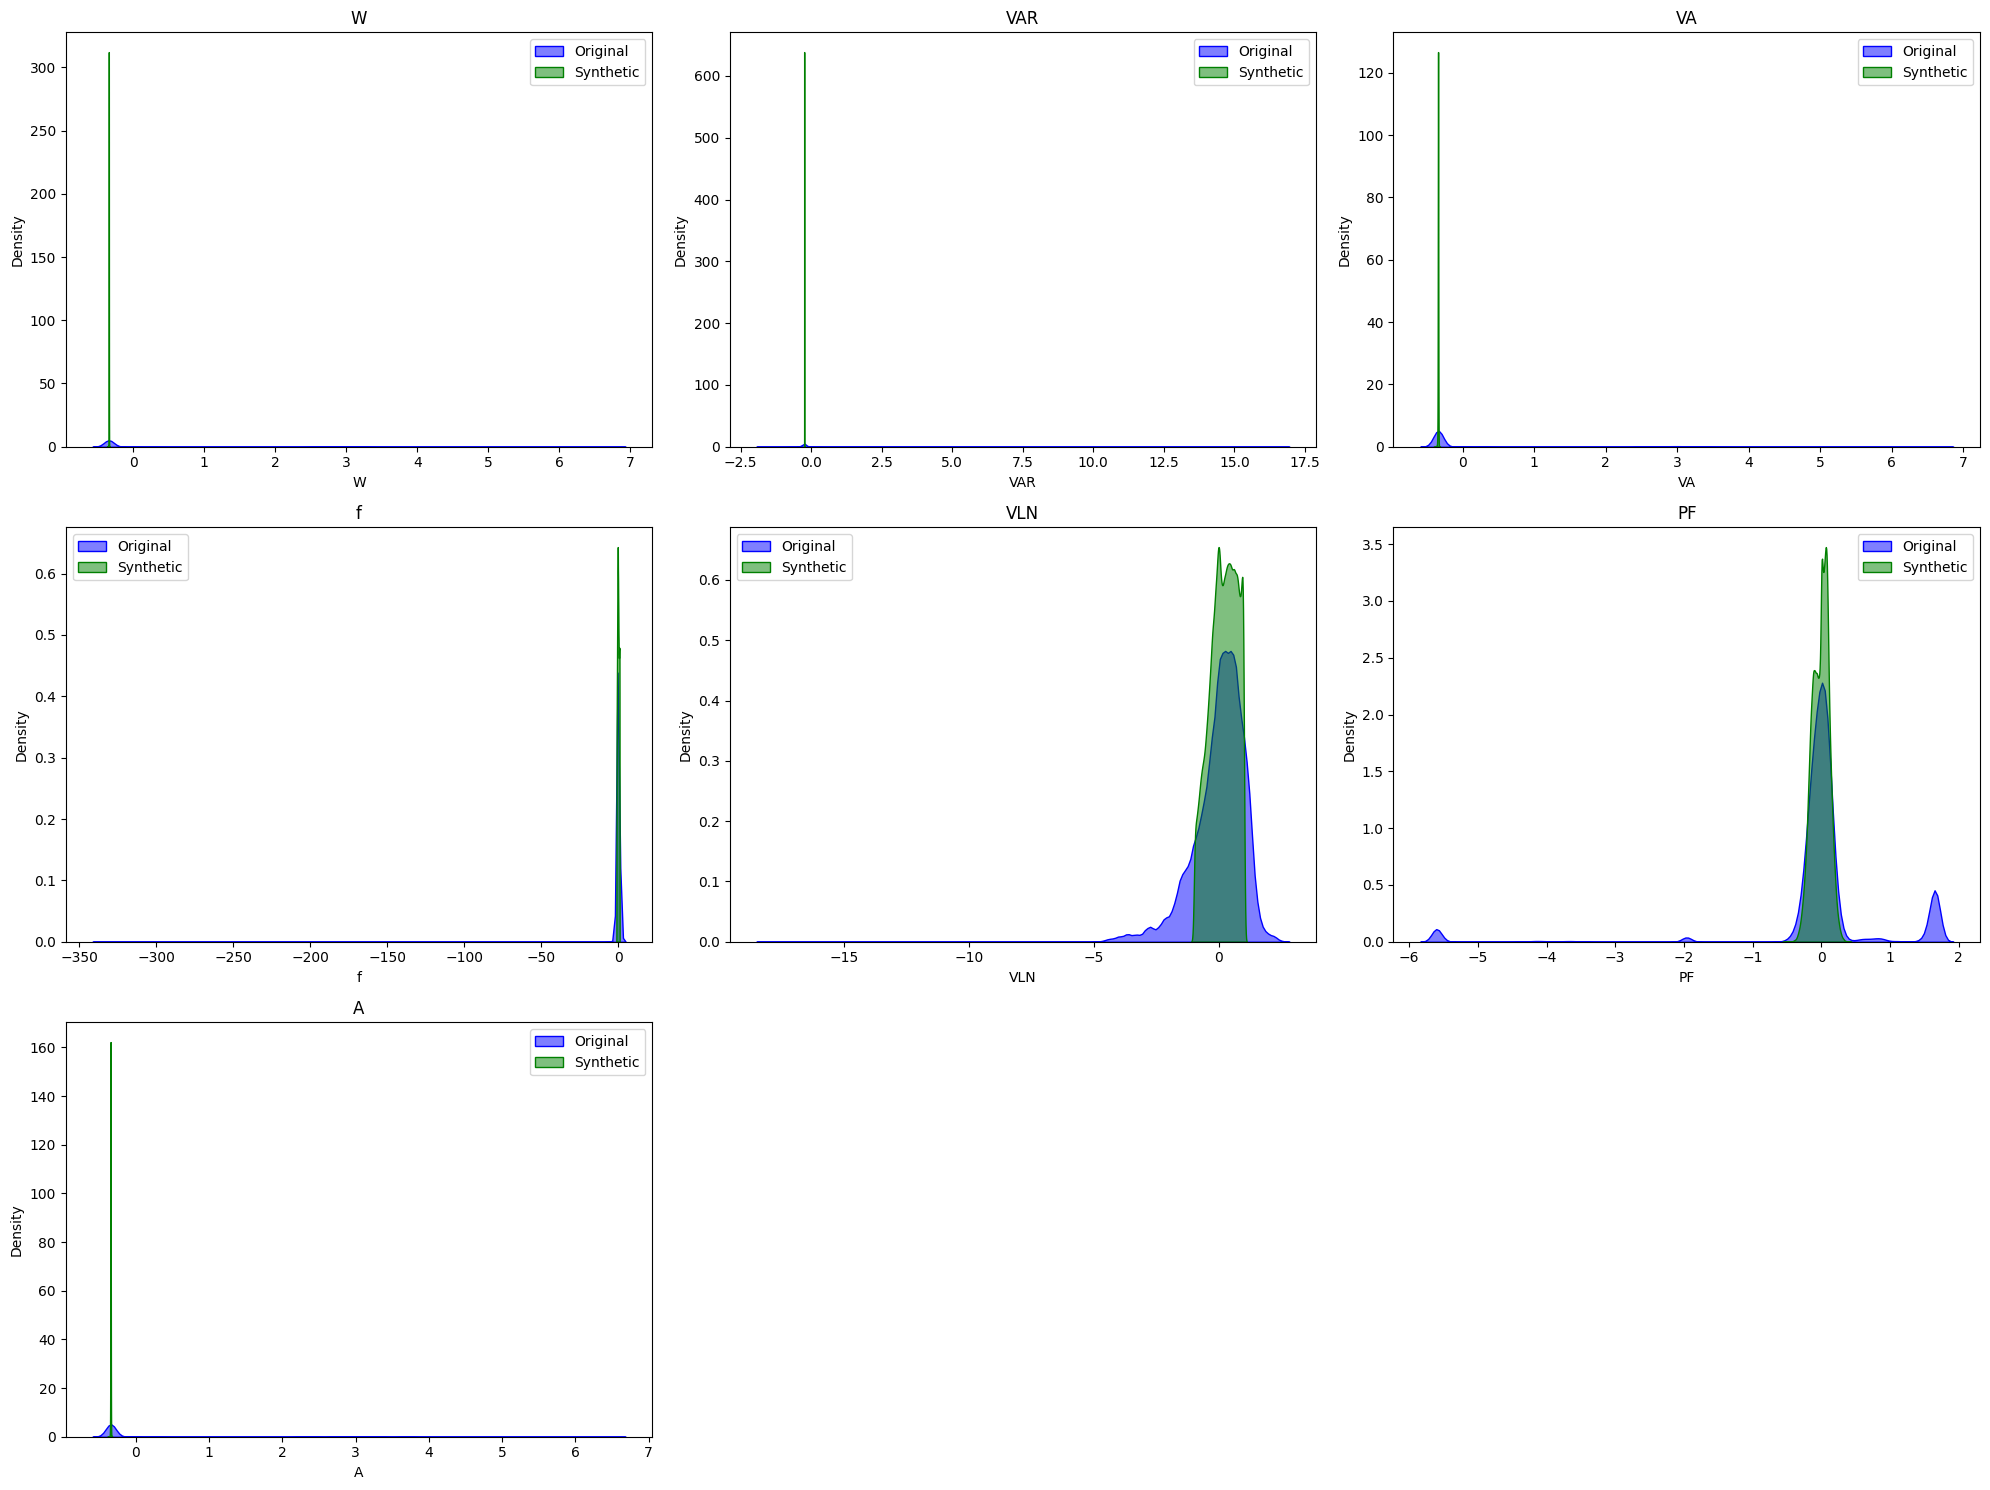

In [81]:
plot_kde(org_df, syn_df)

##### i. Statistical Test

###### KS Test (Kolmogorov-Smirnov)

In [57]:
ks_results = ks_test(org_df, syn_df)
print(ks_results)

  Column  K-S Statistic  p-value
0      W       0.276916      0.0
1    VAR       0.652074      0.0
2     VA       0.383912      0.0
3      f       0.148357      0.0
4    VLN       0.143502      0.0
5     PF       0.110563      0.0
6      A       0.403236      0.0


Results:

A higher K-S statistic indicates a larger difference between the two distributions.

A p-value of 0.0 (or very close to zero) suggests that you can reject the null hypothesis, meaning there is strong evidence that the two distributions are different.

since all p-values are 0.0, it indicates that for each column, the original and synthetic datasets are significantly different from each other.

###### Chi-Square Test

In [63]:
chi_square_results = chi_square_test(org_df, syn_df)
print(chi_square_results)

/data/home/jayadeeps/anaconda3/envs/eda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


  Column  Chi-Square Statistic  p-value
0      W                   inf      0.0
1    VAR                   inf      0.0
2     VA                   inf      0.0
3      f                   inf      0.0
4    VLN                   inf      0.0
5     PF                   inf      0.0
6      A                   inf      0.0


##### ii. Summary

In [72]:
summary_statistics = compare_summary_statistics(org_df, syn_df)
summary_statistics

,Column,Original Mean,Synthetic Mean,Original Median,Synthetic Median,Original Std Dev,Synthetic Std Dev,Original Skewness,Synthetic Skewness,Original Kurtosis,Synthetic Kurtosis,Original IQR,Synthetic IQR
0,W,-0.000539,-0.341940,-0.340957,-0.341907,0.999362,0.001570,2.659070,-0.960048,5.200646,9.766335,0.003060,0.001759
1,VAR,0.000286,-0.244506,-0.244960,-0.244554,1.000600,0.000776,4.468255,0.782402,21.290455,7.400593,0.000000,0.000904
2,VA,-0.000499,-0.344551,-0.340608,-0.344388,0.999461,0.003753,2.660506,-0.827808,5.209912,5.410054,0.007392,0.004317
3,f,0.000586,0.025184,-0.037754,-0.000295,1.073359,0.539986,-48.793675,0.047532,15530.270689,-1.061613,1.261212,0.884569
4,VLN,-0.000012,0.155049,0.163457,0.185666,0.999538,0.518924,-1.145073,-0.262230,2.216074,-0.880744,1.167766,0.817483
5,PF,0.000327,-0.013033,0.008161,0.000465,0.998506,0.118656,-3.477485,-0.188965,18.890173,-0.411389,0.216718,0.177128
6,A,-0.000440,-0.342819,-0.339575,-0.342813,0.999577,0.002850,2.687655,-0.462330,5.403636,4.885147,0.006810,0.003340


##### iii. Earth Mover Distance

In [75]:
emd_results = compute_emd(org_df, syn_df)
print(emd_results)

  Column       EMD
0      W  0.341883
1    VAR  0.267722
2     VA  0.344448
3      f  0.310286
4    VLN  0.306335
5     PF  0.299818
6      A  0.342823


##### iv. GMM Classifier

In [43]:
def fit_gmm_and_test(org_df, syn_df, n_components=3, ):
    # Fit GMM on the original data
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(org_df)
    
    # Predict cluster labels for original data and synthetic data
    org_labels = gmm.predict(org_df)
    syn_labels = gmm.predict(syn_df)
    
    # Evaluate with Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(org_labels, syn_labels)
    
    # Evaluate clustering on the synthetic data using silhouette score
    sil_score_org = silhouette_score(org_df, org_labels)
    sil_score_syn = silhouette_score(syn_df, syn_labels)
    
    print(f"Adjusted Rand Index (ARI) between original and synthetic data: {ari:.4f}")
    print(f"Silhouette Score for original data: {sil_score_org:.4f}")
    print(f"Silhouette Score for synthetic data: {sil_score_syn:.4f}")
    
    # Predict the log likelihood of synthetic data
    syn_log_likelihood = gmm.score(syn_df)
    print(f"Log Likelihood of synthetic data under GMM: {syn_log_likelihood:.4f}")
    
    return org_labels, syn_labels

# Usage
rows_to_consider = 6000
org_labels, syn_labels = fit_gmm_and_test(org_df[:rows_to_consider], syn_df[:rows_to_consider], n_components=3)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- VAR


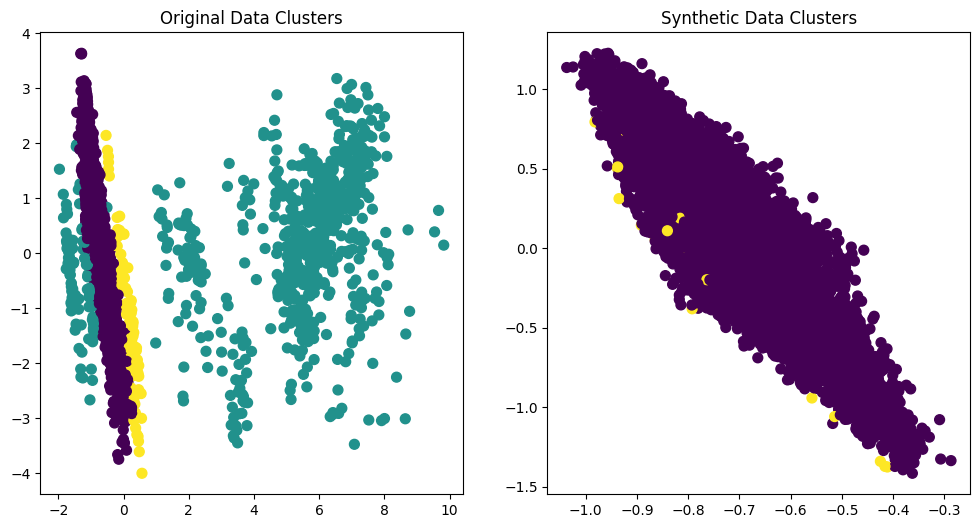

In [43]:
def plot_gmm_results(org_df, syn_df, org_labels, syn_labels):
    # Reduce to 2D using PCA for visualization
    pca = PCA(n_components=2)
    org_pca = pca.fit_transform(org_df)
    syn_pca = pca.transform(syn_df)
    
    # Plot original data clusters
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(org_pca[:, 0], org_pca[:, 1], c=org_labels, cmap='viridis', s=50)
    plt.title('Original Data Clusters')
    
    # Plot synthetic data clusters
    plt.subplot(1, 2, 2)
    plt.scatter(syn_pca[:, 0], syn_pca[:, 1], c=syn_labels, cmap='viridis', s=50)
    plt.title('Synthetic Data Clusters')
    
    plt.show()

# Usage
plot_gmm_results(org_df[:rows_to_consider], syn_df[:rows_to_consider], org_labels, syn_labels)

### 4. CTGAN Architecture, Training and Inference

In [2]:
class TabularDataset(Dataset):
    def __init__(self, data, condition_column_index):
        self.data = data.values
        self.condition_column_index = condition_column_index
        
        self.processed_data = torch.tensor(self.data, dtype=torch.float32)

    def __len__(self):
        return len(self.processed_data)
    
    def __getitem__(self, idx):
        row = self.processed_data[idx]
        
        # Separate the conditional column and feature columns
        condition = row[self.condition_column_index].unsqueeze(0)  # Keep condition as 1D tensor
        features = torch.cat([row[:self.condition_column_index], 
                              row[self.condition_column_index + 1:]])  # Remaining columns as features
        
        return features, condition


#### a. Architechture

In [4]:
class CTGAN(nn.Module):
    def __init__(self, noise_dim, data_dim, conditional_dim):
        super(CTGAN, self).__init__()
        self.generator = Generator(noise_dim, data_dim, conditional_dim)
        self.discriminator = Discriminator(data_dim, conditional_dim)

    def generate(self, noise, condition):
        return self.generator(noise, condition)

    def discriminate(self, data, condition):
        return self.discriminator(data, condition)

class Generator(nn.Module):
    def __init__(self, noise_dim, data_dim, conditional_dim):
        super(Generator, self).__init__()
        
        # Input is noise + condition
        self.fc1 = nn.Linear(noise_dim + conditional_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, data_dim)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh() 
    
    def forward(self, z, condition):
        # Concatenate noise and conditional data
        z_cond = torch.cat([z, condition], dim=1)
        
        x = self.relu(self.fc1(z_cond))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self, data_dim, conditional_dim):
        super(Discriminator, self).__init__()
        
        # Input is data + condition
        self.fc1 = nn.Linear(data_dim + conditional_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, condition):
        # Concatenate real/fake data and conditional data
        x_cond = torch.cat([x, condition], dim=1)
        x = self.relu(self.fc1(x_cond))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
       
        return x

In [31]:
# emb_dim = 100
# c_dim = 1
# op_dim=6
# bs = 64

# gen = CTGAN(emb_dim,op_dim, c_dim)

# z = torch.randn(bs, emb_dim)
# c = torch.randn(bs,c_dim)
# op = gen.generator(z,c)
# op.shape

torch.Size([64, 6])

#### b. Training


In [ ]:
def train_ctgan(model, data_loader, emb_dim, c_dim, num_epochs, lr_gen, lr_disc, device):
    model.generator.to(device)
    model.discriminator.to(device)
    
    # Loss and optimizers
    criterion = nn.BCELoss()
    optimizer_g = torch.optim.Adam(model.generator.parameters(), lr=lr_gen)
    optimizer_d = torch.optim.Adam(model.discriminator.parameters(), lr=lr_disc)

    for epoch in range(num_epochs):
        # Wrap data_loader with tqdm for progress tracking
        with tqdm(total=len(data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
            for features, condition in data_loader:
                features, condition = features.to(device), condition.to(device)

                
                # Create labels
                real_labels = torch.ones(features.size(0), 1).to(device)
                fake_labels = torch.zeros(features.size(0), 1).to(device)

                # Train Discriminator
                for i in range(2):
                    # Generate noise and fake data conditioned on `condition`
                    noise = torch.randn(features.size(0), emb_dim).to(device)
                    fake_data = model.generator(noise, condition)
                
                    optimizer_d.zero_grad()
                    real_preds = model.discriminator(features, condition)
                    real_loss = criterion(real_preds, real_labels)

                    fake_preds = model.discriminator(fake_data.detach(), condition)
                    fake_loss = criterion(fake_preds, fake_labels)

                    d_loss = real_loss + fake_loss
                    d_loss.backward()
                    optimizer_d.step()

                # Train Generator
                optimizer_g.zero_grad()
                noise = torch.randn(features.size(0), emb_dim).to(device)
                generated_data = model.generator(noise, condition)
                fake_preds = model.discriminator(generated_data, condition)
                real_labels = torch.ones(features.size(0), 1).to(device)
                
                g_loss = criterion(fake_preds, real_labels)
                g_loss.backward()
                optimizer_g.step()

                # Update the progress bar
                pbar.set_postfix({'d_loss': d_loss.item(), 'g_loss': g_loss.item()})
                pbar.update(1)  # Increment the progress bar

        print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")


In [71]:

emb_dim = 100
c_dim = 1
op_dim=6
bs = 64
epochs = 10000
lr_gen = 0.001
lr_disc = 0.001 
device = "cuda"
df = pd.read_csv("/data/home/jayadeeps/eda/Datasets/train_data.csv")
dataset = TabularDataset(data=df, condition_column_index=1)

model = CTGAN(emb_dim,op_dim, c_dim)

data_loader = DataLoader(dataset, batch_size=bs, shuffle=True)
train_ctgan(model, data_loader, emb_dim=emb_dim, c_dim = c_dim, num_epochs = epochs, lr_gen = lr_gen, lr_disc = lr_disc, device = device)

NameError: name 'train_ctgan' is not defined

#### c. Inference


In [5]:
def generate_synthetic_data_cgan(model,condition_column, num_samples,embedding_dim, device="cpu"):
  
    with torch.no_grad():
        noise = torch.randn(num_samples, embedding_dim).to(device)
        
        condition_tensor = torch.tensor(condition_column.values, dtype=torch.float32).to(device)
        condition_tensor = condition_tensor[:num_samples]  # Limit to num_samples
        if condition_tensor.dim() == 1:
            condition_tensor = condition_tensor.unsqueeze(1)  # Add extra dimension if needed
    
        synthetic_data = model.generator(noise, condition_tensor)
        synthetic_data = synthetic_data.detach().cpu().numpy()
        columns = ['W', 'VA', 'f', 'VLN', 'PF', 'A']
        df = pd.DataFrame(synthetic_data, columns = columns)
    return df

In [48]:
condition_value = 1
num_samples = 100000
emb_dim = 100
c_dim = 1
op_dim=6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CTGAN(emb_dim,op_dim, c_dim)
state_dict = torch.load("/data/home/jayadeeps/eda/Models/cdcgan/ctgan_epoch_100.pth")
model.load_state_dict(state_dict)

model.generator.to(device)
model.generator.eval()

org_df = pd.read_csv("/data/home/jayadeeps/eda/Datasets/test_data.csv")

condition_column = org_df["VAR"]

syn_df = generate_synthetic_data_cgan(model, condition_column, num_samples, emb_dim, device)

/tmp/ipykernel_3431621/1016061661.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/data/home/jayadeeps/eda/Models/cdcgan/ctgan_epoch_100.pth")


In [49]:
org_df_filtered = org_df.drop(columns=["VAR"]).iloc[:num_samples,:]

In [50]:
org_df_filtered.columns

Index(['W', 'VA', 'f', 'VLN', 'PF', 'A'], dtype='object')

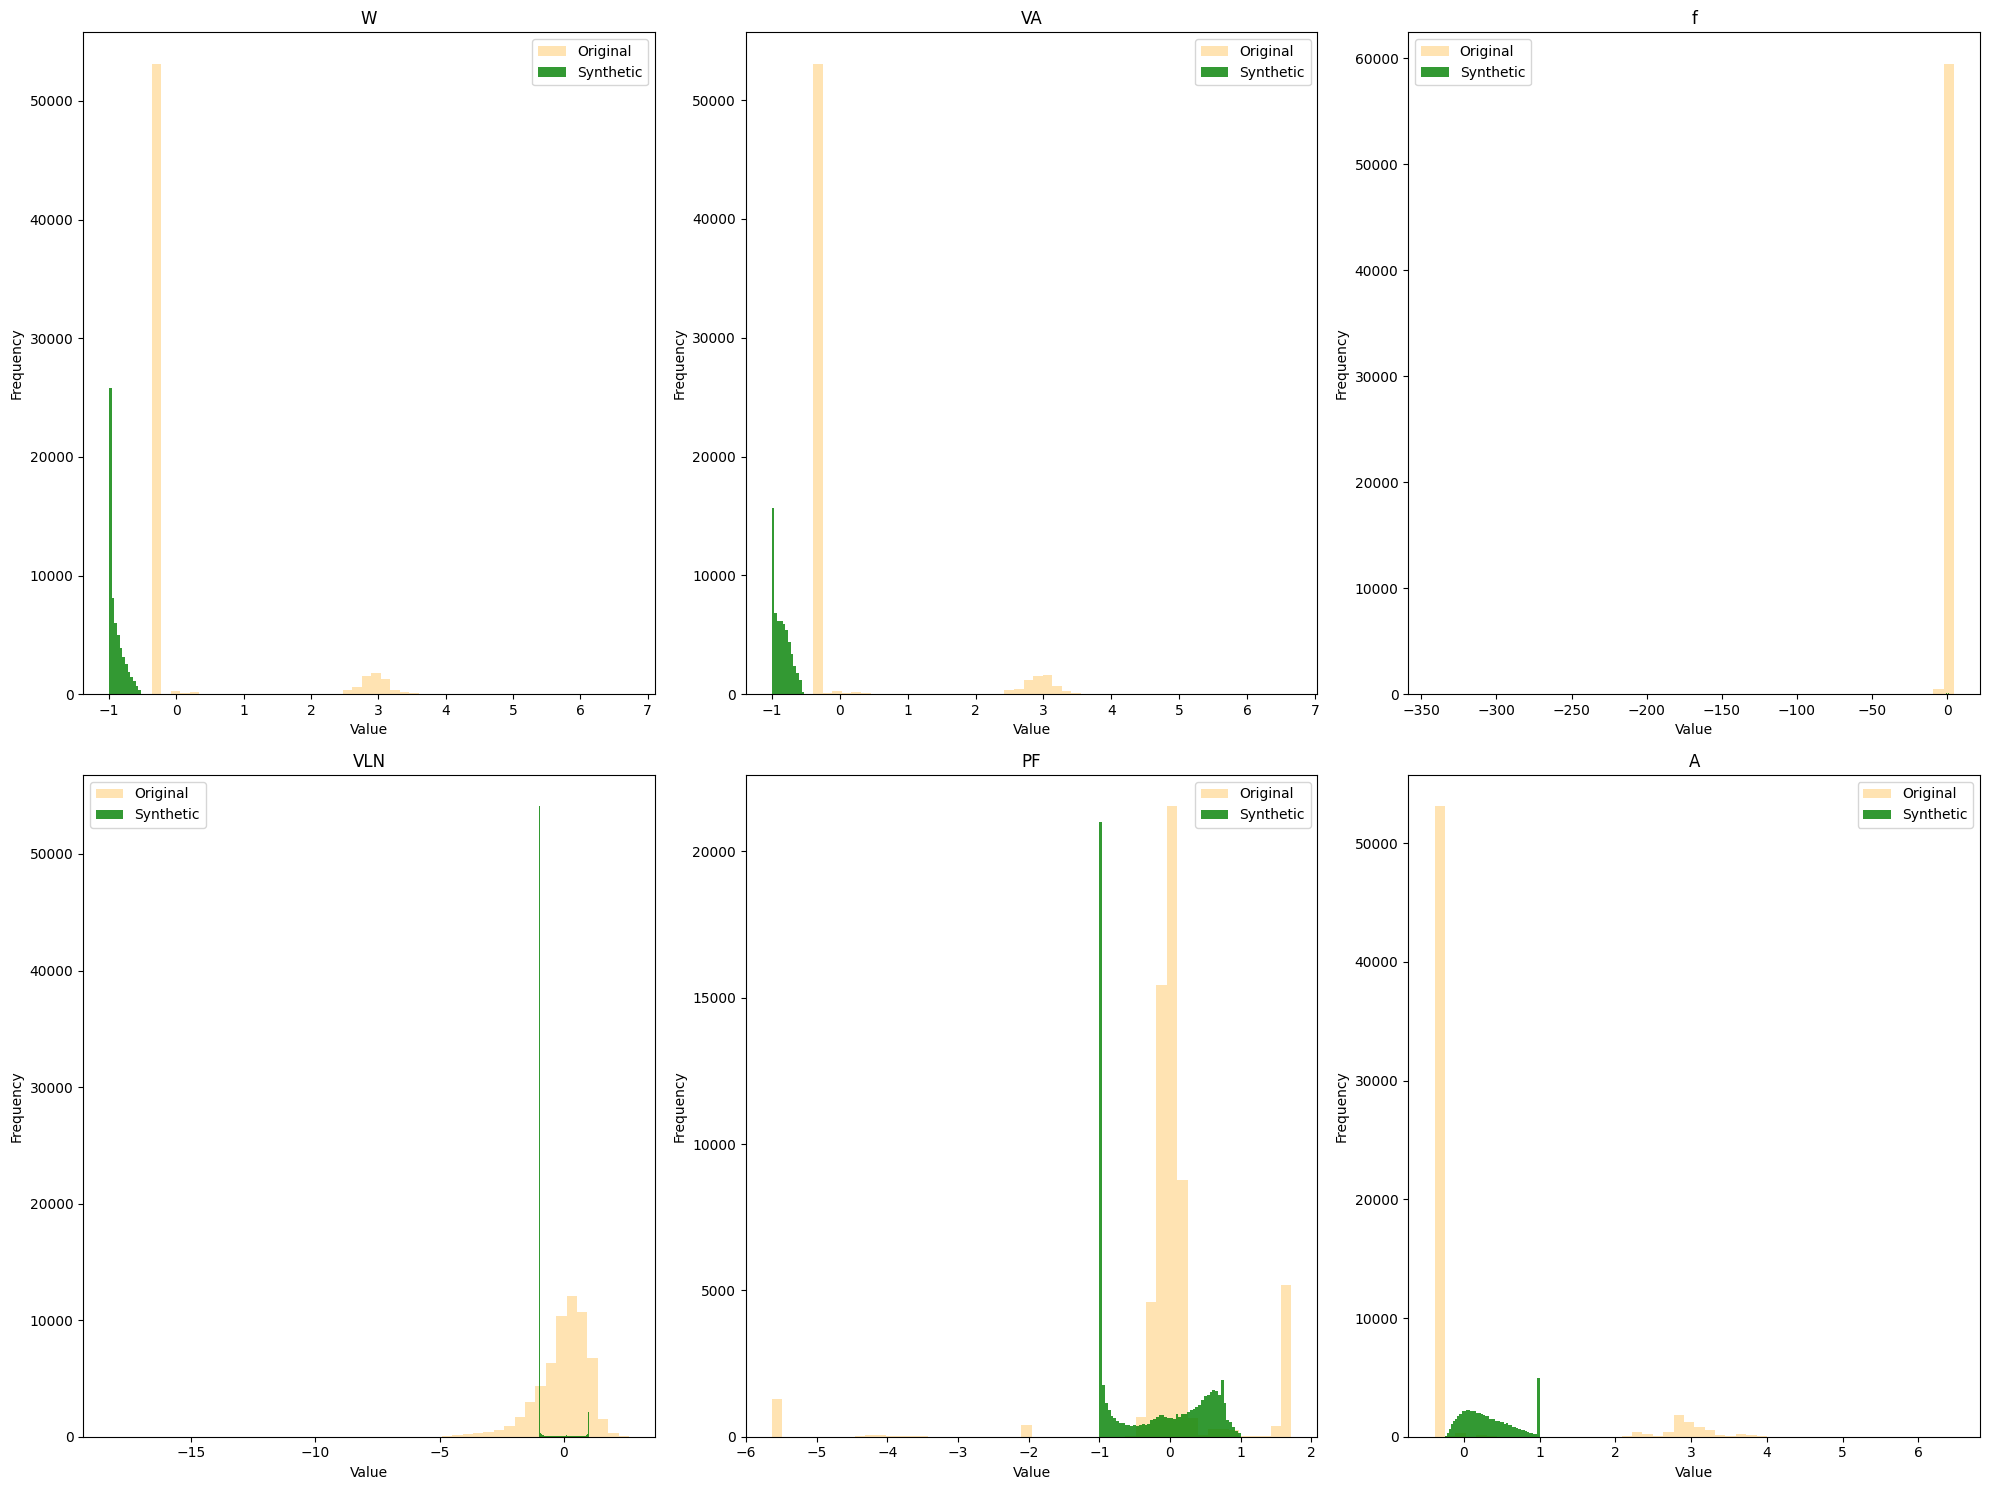

In [37]:
hist_plot(org_df_filtered,syn_df)

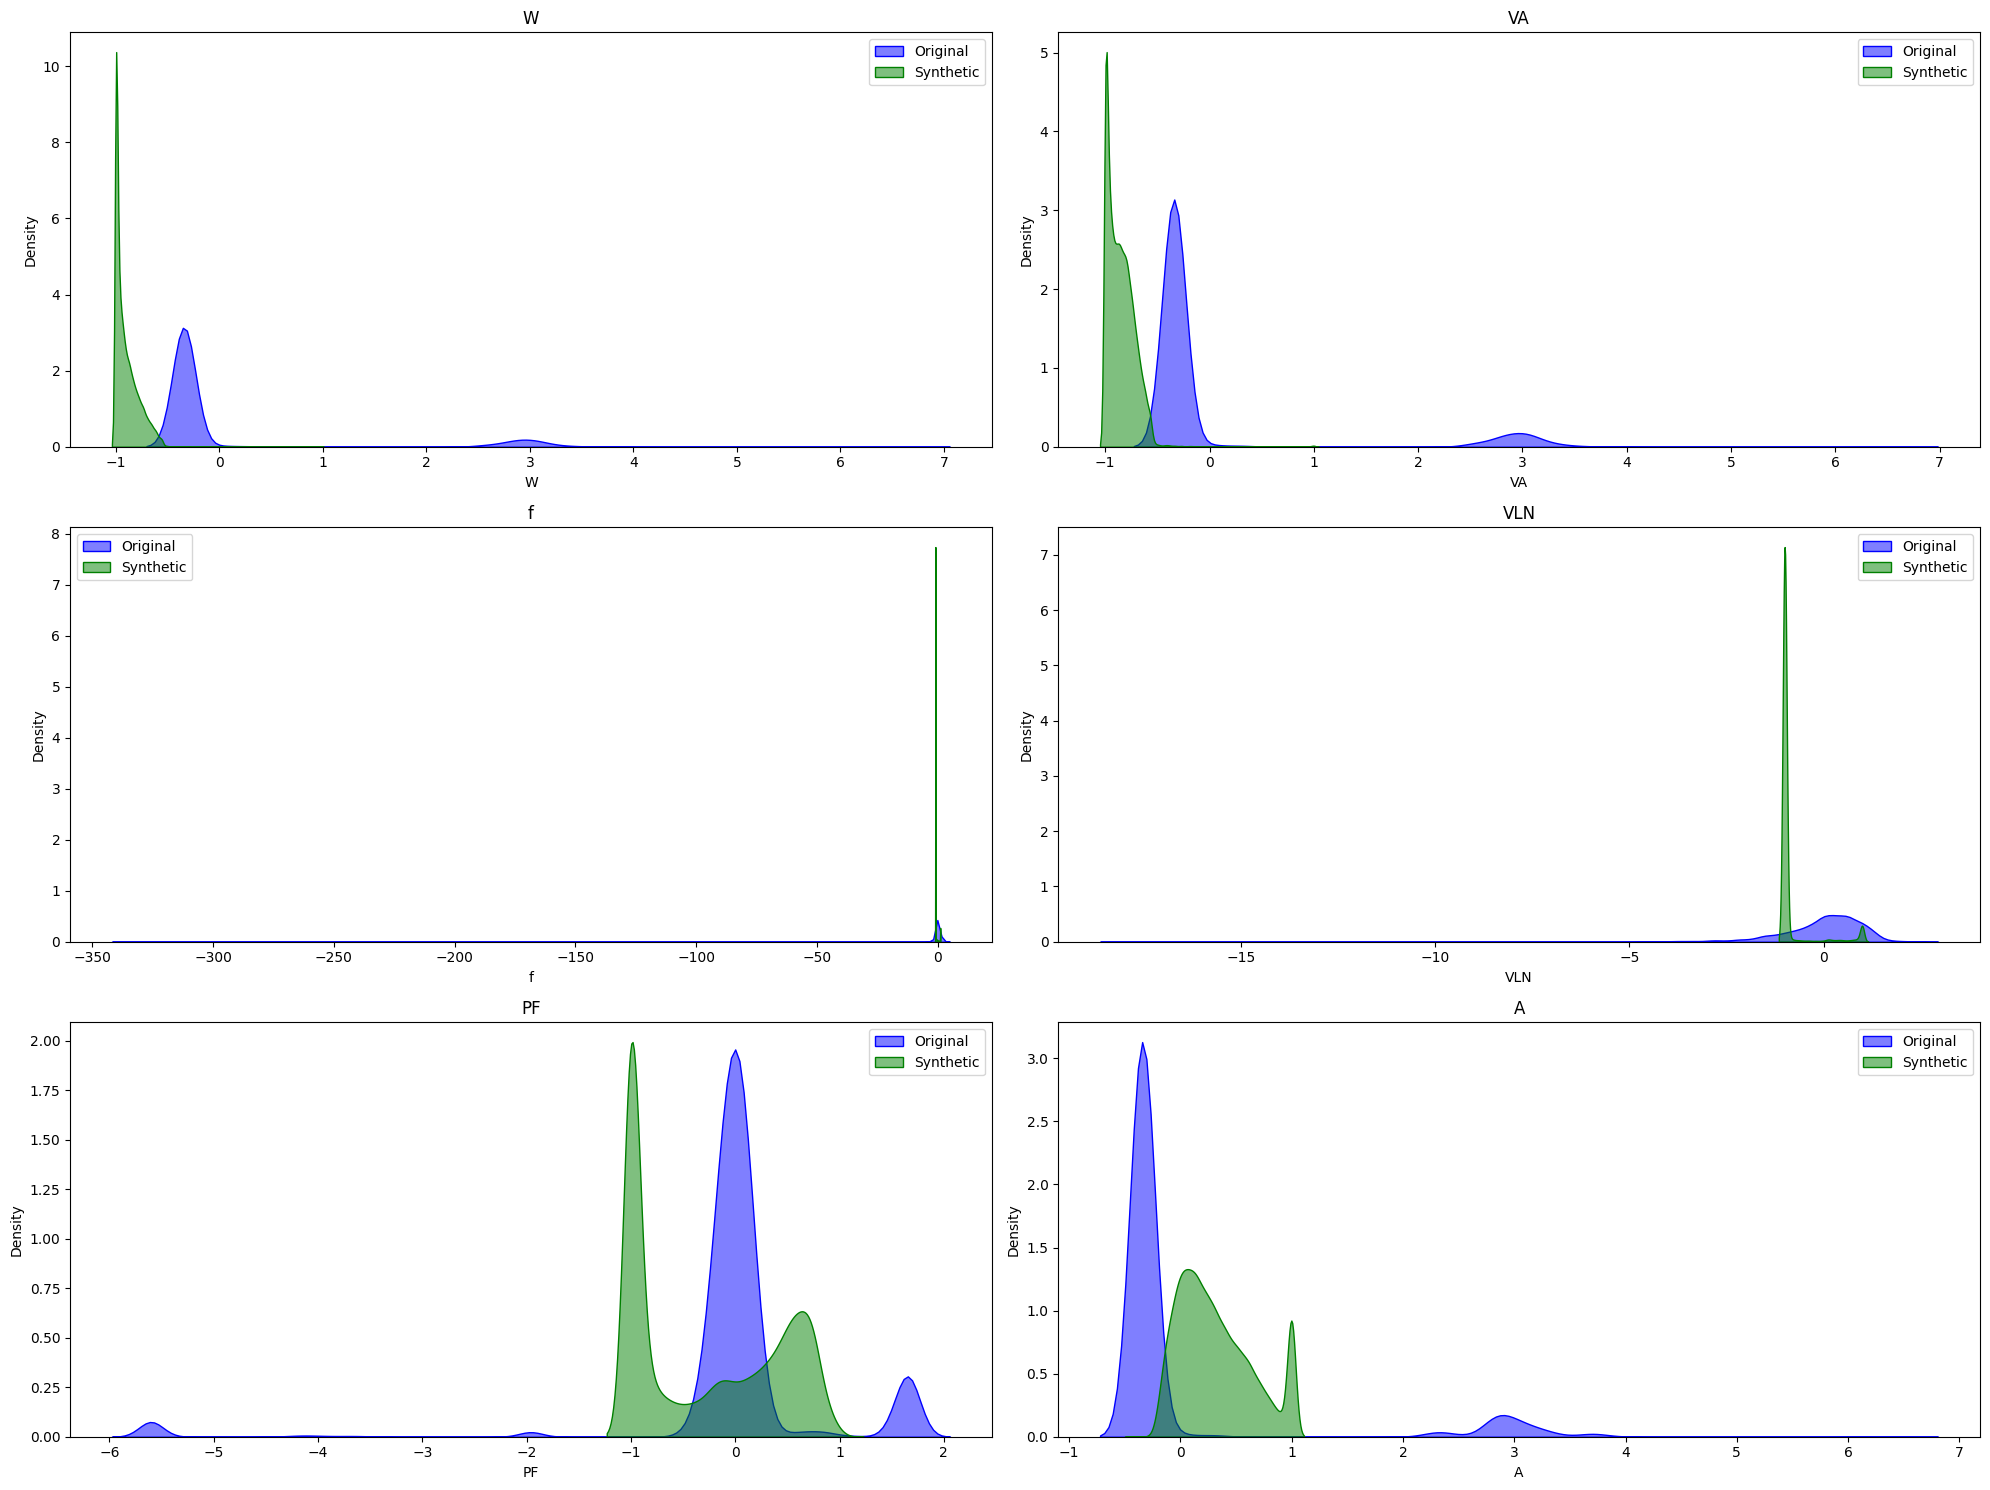

In [38]:
plot_kde(org_df_filtered, syn_df)

In [39]:
ks_results = ks_test(org_df_filtered, syn_df)
print(ks_results)

  Column  K-S Statistic  p-value
0      W       0.999483      0.0
1     VA       0.993433      0.0
2      f       0.756783      0.0
3    VLN       0.749017      0.0
4     PF       0.467183      0.0
5      A       0.885050      0.0


In [40]:
chi_square_results = chi_square_test(org_df_filtered, syn_df)
print(chi_square_results)

/data/home/jayadeeps/anaconda3/envs/eda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


  Column  Chi-Square Statistic  p-value
0      W                   inf      0.0
1     VA                   inf      0.0
2      f                   inf      0.0
3    VLN                   inf      0.0
4     PF                   inf      0.0
5      A                   inf      0.0


In [41]:
summary_statistics = compare_summary_statistics(org_df_filtered, syn_df)
summary_statistics

,Column,Original Mean,Synthetic Mean,Original Median,Synthetic Median,Original Std Dev,Synthetic Std Dev,Original Skewness,Synthetic Skewness,Original Kurtosis,Synthetic Kurtosis,Original IQR,Synthetic IQR
0,W,0.009644,-0.900483,-0.340954,-0.941157,1.012478,0.112246,2.606815,1.675143,4.929429,8.126754,0.003094,1.524280e-01
1,VA,0.009662,-0.848859,-0.340567,-0.871753,1.012532,0.149621,2.608109,3.699277,4.936269,33.848118,0.007455,1.941238e-01
2,f,-0.002850,-0.884980,-0.031643,-1.000000,1.709787,0.419252,-132.618468,3.820626,26476.170043,13.360445,1.263916,0.000000e+00
3,VLN,-0.008929,-0.868939,0.157164,-1.000000,1.008395,0.455651,-1.235939,3.466186,3.778246,10.496553,1.172426,1.192093e-07
4,PF,-0.003454,-0.279992,0.006560,-0.400548,1.021373,0.696636,-3.447209,0.265056,18.174979,-1.595752,0.217480,1.440043e+00
5,A,0.010317,0.318587,-0.339513,0.252040,1.014551,0.332646,2.635545,0.601752,5.129188,-0.590643,0.006933,4.823344e-01


In [42]:
emd_results = compute_emd(org_df_filtered, syn_df)
print(emd_results)

  Column       EMD
0      W  0.910126
1     VA  0.858521
2      f  1.043545
3    VLN  1.107514
4     PF  0.678246
5      A  0.722344


In [ ]:
def fit_gmm_and_test(org_df, syn_df, n_components=3, ):
    # Fit GMM on the original data
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(org_df)
    
    # Predict cluster labels for original data and synthetic data
    org_labels = gmm.predict(org_df)
    syn_labels = gmm.predict(syn_df)
    
    # Evaluate with Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(org_labels, syn_labels)
    
    # Evaluate clustering on the synthetic data using silhouette score
    sil_score_org = silhouette_score(org_df, org_labels)
    sil_score_syn = silhouette_score(syn_df, syn_labels)
    
    print(f"Adjusted Rand Index (ARI) between original and synthetic data: {ari:.4f}")
    print(f"Silhouette Score for original data: {sil_score_org:.4f}")
    print(f"Silhouette Score for synthetic data: {sil_score_syn:.4f}")
    
    # Predict the log likelihood of synthetic data
    syn_log_likelihood = gmm.score(syn_df)
    print(f"Log Likelihood of synthetic data under GMM: {syn_log_likelihood:.4f}")
    
    return org_labels, syn_labels

def plot_gmm_results(org_df, syn_df, org_labels, syn_labels):
    # Reduce to 2D using PCA for visualization
    pca = PCA(n_components=2)
    org_pca = pca.fit_transform(org_df)
    syn_pca = pca.transform(syn_df)
    
    # Plot original data clusters
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(org_pca[:, 0], org_pca[:, 1], c=org_labels, cmap='viridis', s=50)
    plt.title('Original Data Clusters')
    
    # Plot synthetic data clusters
    plt.subplot(1, 2, 2)
    plt.scatter(syn_pca[:, 0], syn_pca[:, 1], c=syn_labels, cmap='viridis', s=50)
    plt.title('Synthetic Data Clusters')
    
    plt.show()

In [54]:
org_labels, syn_labels = fit_gmm_and_test(org_df_filtered, syn_df, n_components=3)

Adjusted Rand Index (ARI) between original and synthetic data: 0.0044
Silhouette Score for original data: 0.6167
Silhouette Score for synthetic data: 0.4756
Log Likelihood of synthetic data under GMM: -87.1193


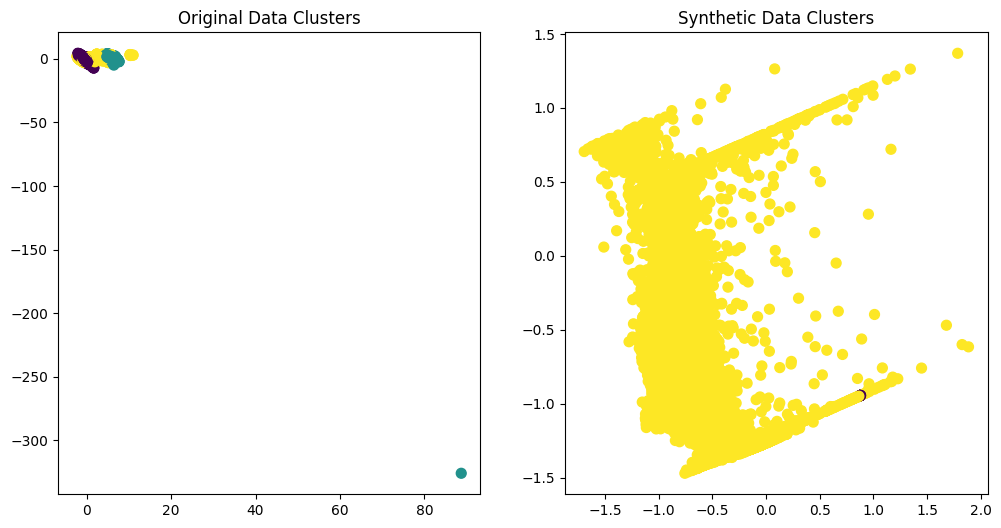

In [55]:
plot_gmm_results(org_df_filtered, syn_df, org_labels, syn_labels)

### 5. Modified CTGAN Architecture, Training and Inference

In [56]:
SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo',
    ['column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'],
)


class DataTransformer(object):

    def __init__(self, max_clusters=10, weight_threshold=0.005):
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        column_name = data.columns[0]
        gm = ClusterBasedNormalizer(
            missing_value_generation='from_column',
            max_clusters=min(len(data), self._max_clusters),
            weight_threshold=self._weight_threshold,
        )
        gm.fit(data, column_name)
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='continuous',
            transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components,
        )

    def _fit_discrete(self, data):
        column_name = data.columns[0]
        ohe = OneHotEncoder()
        ohe.fit(data, column_name)
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='discrete',
            transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories,
        )

    def fit(self, raw_data, discrete_columns=()):
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        flattened_column = data[column_name].to_numpy().flatten()
        data = data.assign(**{column_name: flattened_column})
        gm = column_transform_info.transform
        transformed = gm.transform(data)

        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def _synchronous_transform(self, raw_data, column_transform_info_list):
        column_data_list = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return column_data_list

    def _parallel_transform(self, raw_data, column_transform_info_list):
        processes = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            process = None
            if column_transform_info.column_type == 'continuous':
                process = delayed(self._transform_continuous)(column_transform_info, data)
            else:
                process = delayed(self._transform_discrete)(column_transform_info, data)
            processes.append(process)

        return Parallel(n_jobs=-1)(processes)

    def transform(self, raw_data):
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        if raw_data.shape[0] < 500:
            column_data_list = self._synchronous_transform(
                raw_data, self._column_transform_info_list
            )
        else:
            column_data_list = self._parallel_transform(raw_data, self._column_transform_info_list)

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_sdtypes())).astype(float)
        data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data)

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_sdtypes()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st : st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st
                )
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data
                )

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = pd.DataFrame(recovered_data, columns=column_names).astype(
            self._column_raw_dtypes
        )
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot),
        }

In [57]:
"""BaseSynthesizer module."""

@contextlib.contextmanager
def set_random_states(random_state, set_model_random_state):
    original_np_state = np.random.get_state()
    original_torch_state = torch.get_rng_state()

    random_np_state, random_torch_state = random_state

    np.random.set_state(random_np_state.get_state())
    torch.set_rng_state(random_torch_state.get_state())

    try:
        yield
    finally:
        current_np_state = np.random.RandomState()
        current_np_state.set_state(np.random.get_state())
        current_torch_state = torch.Generator()
        current_torch_state.set_state(torch.get_rng_state())
        set_model_random_state((current_np_state, current_torch_state))

        np.random.set_state(original_np_state)
        torch.set_rng_state(original_torch_state)


def random_state(function):
    def wrapper(self, *args, **kwargs):
        if self.random_states is None:
            return function(self, *args, **kwargs)

        else:
            with set_random_states(self.random_states, self.set_random_state):
                return function(self, *args, **kwargs)

    return wrapper


class BaseSynthesizer:
    random_states = None

    def __getstate__(self):
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        state = self.__dict__.copy()
        self.set_device(device_backup)
        if (
            isinstance(self.random_states, tuple)
            and isinstance(self.random_states[0], np.random.RandomState)
            and isinstance(self.random_states[1], torch.Generator)
        ):
            state['_numpy_random_state'] = self.random_states[0].get_state()
            state['_torch_random_state'] = self.random_states[1].get_state()
            state.pop('random_states')

        return state

    def __setstate__(self, state):
        if '_numpy_random_state' in state and '_torch_random_state' in state:
            np_state = state.pop('_numpy_random_state')
            torch_state = state.pop('_torch_random_state')

            current_torch_state = torch.Generator()
            current_torch_state.set_state(torch_state)

            current_numpy_state = np.random.RandomState()
            current_numpy_state.set_state(np_state)
            state['random_states'] = (current_numpy_state, current_torch_state)

        self.__dict__ = state
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.set_device(device)

    def save(self, path):
        """Save the model in the passed `path`."""
        device_backup = self._device
        self.set_device(torch.device('cpu'))
        torch.save(self, path)
        self.set_device(device_backup)

    @classmethod
    def load(cls, path):
        """Load the model stored in the passed `path`."""
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model = torch.load(path)
        model.set_device(device)
        return model

    def set_random_state(self, random_state):
        if random_state is None:
            self.random_states = random_state
        elif isinstance(random_state, int):
            self.random_states = (
                np.random.RandomState(seed=random_state),
                torch.Generator().manual_seed(random_state),
            )
        elif (
            isinstance(random_state, tuple)
            and isinstance(random_state[0], np.random.RandomState)
            and isinstance(random_state[1], torch.Generator)
        ):
            self.random_states = random_state
        else:
            raise TypeError(
                f'`random_state` {random_state} expected to be an int or a tuple of '
                '(`np.random.RandomState`, `torch.Generator`)'
            )

In [58]:
"""DataSampler module."""

class DataSampler(object):
    def __init__(self, data, output_info, log_frequency):
        self._data_length = len(data)

        def is_discrete_column(column_info):
            return len(column_info) == 1 and column_info[0].activation_fn == 'softmax'

        n_discrete_columns = sum([
            1 for column_info in output_info if is_discrete_column(column_info)
        ])

        self._discrete_column_matrix_st = np.zeros(n_discrete_columns, dtype='int32')

        self._rid_by_cat_cols = []

        # Compute _rid_by_cat_cols
        st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim

                rid_by_cat = []
                for j in range(span_info.dim):
                    rid_by_cat.append(np.nonzero(data[:, st + j])[0])
                self._rid_by_cat_cols.append(rid_by_cat)
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])
        assert st == data.shape[1]

        # Prepare an interval matrix for efficiently sample conditional vector
        max_category = max(
            [column_info[0].dim for column_info in output_info if is_discrete_column(column_info)],
            default=0,
        )

        self._discrete_column_cond_st = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_n_category = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_category_prob = np.zeros((n_discrete_columns, max_category))
        self._n_discrete_columns = n_discrete_columns
        self._n_categories = sum([
            column_info[0].dim for column_info in output_info if is_discrete_column(column_info)
        ])

        st = 0
        current_id = 0
        current_cond_st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim
                category_freq = np.sum(data[:, st:ed], axis=0)
                if log_frequency:
                    category_freq = np.log(category_freq + 1)
                category_prob = category_freq / np.sum(category_freq)
                self._discrete_column_category_prob[current_id, : span_info.dim] = category_prob
                self._discrete_column_cond_st[current_id] = current_cond_st
                self._discrete_column_n_category[current_id] = span_info.dim
                current_cond_st += span_info.dim
                current_id += 1
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])

    def _random_choice_prob_index(self, discrete_column_id):
        probs = self._discrete_column_category_prob[discrete_column_id]
        r = np.expand_dims(np.random.rand(probs.shape[0]), axis=1)
        return (probs.cumsum(axis=1) > r).argmax(axis=1)

    def sample_condvec(self, batch):
        if self._n_discrete_columns == 0:
            return None

        discrete_column_id = np.random.choice(np.arange(self._n_discrete_columns), batch)

        cond = np.zeros((batch, self._n_categories), dtype='float32')
        mask = np.zeros((batch, self._n_discrete_columns), dtype='float32')
        mask[np.arange(batch), discrete_column_id] = 1
        category_id_in_col = self._random_choice_prob_index(discrete_column_id)
        category_id = self._discrete_column_cond_st[discrete_column_id] + category_id_in_col
        cond[np.arange(batch), category_id] = 1

        return cond, mask, discrete_column_id, category_id_in_col

    def sample_original_condvec(self, batch):
        """Generate the conditional vector for generation use original frequency."""
        if self._n_discrete_columns == 0:
            return None

        category_freq = self._discrete_column_category_prob.flatten()
        category_freq = category_freq[category_freq != 0]
        category_freq = category_freq / np.sum(category_freq)
        col_idxs = np.random.choice(np.arange(len(category_freq)), batch, p=category_freq)
        cond = np.zeros((batch, self._n_categories), dtype='float32')
        cond[np.arange(batch), col_idxs] = 1

        return cond

    def sample_data(self, data, n, col, opt):
        if col is None:
            idx = np.random.randint(len(data), size=n)
            return data[idx]

        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self._rid_by_cat_cols[c][o]))

        return data[idx]

    def dim_cond_vec(self):
        """Return the total number of categories."""
        return self._n_categories

    def generate_cond_from_condition_column_info(self, condition_info, batch):
        """Generate the condition vector."""
        vec = np.zeros((batch, self._n_categories), dtype='float32')
        id_ = self._discrete_column_matrix_st[condition_info['discrete_column_id']]
        id_ += condition_info['value_id']
        vec[:, id_] = 1
        return vec

In [77]:
"""CTGAN Module"""


class Discriminator(Module):
    """Discriminator for the CTGAN."""

    def __init__(self, input_dim, discriminator_dim, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        """Compute the gradient penalty."""
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)
        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input_):
        """Apply the Discriminator to the `input_`."""
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim))

class Residual(nn.Module):
    """Residual layer for the CTGAN."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)
    
class Generator(Module):
    """Generator for the CTGAN."""

    def __init__(self, embedding_dim, generator_dim, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        data = self.seq(input_)
        return data
    
class CTGAN(BaseSynthesizer):
    """Conditional Table GAN Synthesizer."""

    def __init__(
        self,
        embedding_dim=128,
        generator_dim=(256, 256),
        discriminator_dim=(256, 256),
        generator_lr=2e-4,
        generator_decay=1e-6,
        discriminator_lr=2e-4,
        discriminator_decay=1e-6,
        batch_size=500,
        discriminator_steps=1,
        log_frequency=True,
        verbose=True,
        epochs=300,
        pac=10,
        cuda=True,
    ):
        assert batch_size % 2 == 0

        self._embedding_dim = embedding_dim
        self._generator_dim = generator_dim
        self._discriminator_dim = discriminator_dim
        self._generator_lr = generator_lr
        self._generator_decay = generator_decay
        self._discriminator_lr = discriminator_lr
        self._discriminator_decay = discriminator_decay
        self._batch_size = batch_size
        self._discriminator_steps = discriminator_steps
        self._log_frequency = log_frequency
        self._verbose = verbose
        self._epochs = epochs
        self.pac = pac

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)
        self._transformer = None
        self._data_sampler = None
        self._generator = None
        self.loss_values = None

    @staticmethod
    def _gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
        """Deals with the instability of the gumbel_softmax for older versions of torch."""
        for _ in range(10):
            transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
            if not torch.isnan(transformed).any():
                return transformed
        raise ValueError('gumbel_softmax returning NaN.')

    def _apply_activate(self, data):
        """Apply proper activation function to the output of the generator."""
        data_t = []
        st = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if span_info.activation_fn == 'tanh':
                    ed = st + span_info.dim
                    data_t.append(torch.tanh(data[:, st:ed]))
                    st = ed
                elif span_info.activation_fn == 'softmax':
                    ed = st + span_info.dim
                    transformed = self._gumbel_softmax(data[:, st:ed], tau=0.2)
                    data_t.append(transformed)
                    st = ed
                else:
                    raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

        return torch.cat(data_t, dim=1)

    def _cond_loss(self, data, c, m):
        """Compute the cross entropy loss on the fixed discrete column."""
        loss = []
        st = 0
        st_c = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                    st += span_info.dim
                else:
                    ed = st + span_info.dim
                    ed_c = st_c + span_info.dim
                    tmp = functional.cross_entropy(
                        data[:, st:ed], torch.argmax(c[:, st_c:ed_c], dim=1), reduction='none'
                    )
                    loss.append(tmp)
                    st = ed
                    st_c = ed_c

        loss = torch.stack(loss, dim=1)
        return (loss * m).sum() / data.size()[0]

    def _validate_discrete_columns(self, train_data, discrete_columns):
        """Check whether ``discrete_columns`` exists in ``train_data``."""
        if isinstance(train_data, pd.DataFrame):
            invalid_columns = set(discrete_columns) - set(train_data.columns)
        elif isinstance(train_data, np.ndarray):
            invalid_columns = [
                column for column in discrete_columns if column < 0 or column >= train_data.shape[1]
            ]
        else:
            raise TypeError('``train_data`` should be either pd.DataFrame or np.array.')

        if invalid_columns:
            raise ValueError(f'Invalid columns found: {invalid_columns}')

    @random_state
    def fit(self, train_data, discrete_columns=(), epochs=None):
        self._validate_discrete_columns(train_data, discrete_columns)

        if epochs is None:
            epochs = self._epochs
        else:
            warnings.warn(
                (
                    '`epochs` argument in `fit` method has been deprecated and will be removed '
                    'in a future version. Please pass `epochs` to the constructor instead'
                ),
                DeprecationWarning,
            )

        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)

        self._data_sampler = DataSampler(
            train_data, self._transformer.output_info_list, self._log_frequency
        )

        data_dim = self._transformer.output_dimensions

        self._generator = Generator(
            self._embedding_dim + self._data_sampler.dim_cond_vec(), self._generator_dim, data_dim
        ).to(self._device)

        discriminator = Discriminator(
            data_dim + self._data_sampler.dim_cond_vec(), self._discriminator_dim, pac=self.pac
        ).to(self._device)

        optimizerG = optim.Adam(
            self._generator.parameters(),
            lr=self._generator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._generator_decay,
        )

        optimizerD = optim.Adam(
            discriminator.parameters(),
            lr=self._discriminator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._discriminator_decay,
        )

        mean = torch.zeros(self._batch_size, self._embedding_dim, device=self._device)
        std = mean + 1

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Distriminator Loss'])

        epoch_iterator = tqdm(range(epochs), disable=(not self._verbose))
        # if self._verbose:
        description = 'Gen. ({gen:.2f}) | Discrim. ({dis:.2f})'
        epoch_iterator.set_description(description.format(gen=0, dis=0))

        steps_per_epoch = max(len(train_data) // self._batch_size, 1)
        for i in epoch_iterator:
            batch_iterator = tqdm(range(steps_per_epoch), leave=False, desc="Batch Progress")
        
            for id_ in batch_iterator:
                for n in range(self._discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std)

                    condvec = self._data_sampler.sample_condvec(self._batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col, opt
                        )
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to(self._device)
                        m1 = torch.from_numpy(m1).to(self._device)
                        fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange(self._batch_size)
                        np.random.shuffle(perm)
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col[perm], opt[perm]
                        )
                        c2 = c1[perm]

                    fake = self._generator(fakez)
                    fakeact = self._apply_activate(fake)

                    real = torch.from_numpy(real.astype('float32')).to(self._device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        real_cat = real
                        fake_cat = fakeact

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat, self._device, self.pac
                    )
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

                    optimizerD.zero_grad(set_to_none=False)
                    pen.backward(retain_graph=True)
                    loss_d.backward()
                    optimizerD.step()

                fakez = torch.normal(mean=mean, std=std)
                condvec = self._data_sampler.sample_condvec(self._batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self._device)
                    m1 = torch.from_numpy(m1).to(self._device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self._generator(fakez)
                fakeact = self._apply_activate(fake)

                if c1 is not None:
                    y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = self._cond_loss(fake, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                optimizerG.zero_grad(set_to_none=False)
                loss_g.backward()
                optimizerG.step()

            generator_loss = loss_g.detach().cpu().item()
            discriminator_loss = loss_d.detach().cpu().item()

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i],
                'Generator Loss': [generator_loss],
                'Discriminator Loss': [discriminator_loss],
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            
            epoch_iterator.set_description(description.format(gen=generator_loss, dis=discriminator_loss))
                

    @random_state
    def sample(self, n, condition_column=None, condition_value=None):
        if condition_column is not None and condition_value is not None:
            condition_info = self._transformer.convert_column_name_value_to_id(
                condition_column, condition_value
            )
            global_condition_vec = self._data_sampler.generate_cond_from_condition_column_info(
                condition_info, self._batch_size
            )
        else:
            global_condition_vec = None

        steps = n // self._batch_size + 1
        data = []
        for i in range(steps):
            mean = torch.zeros(self._batch_size, self._embedding_dim)
            std = mean + 1
            fakez = torch.normal(mean=mean, std=std).to(self._device)

            if global_condition_vec is not None:
                condvec = global_condition_vec.copy()
            else:
                condvec = self._data_sampler.sample_original_condvec(self._batch_size)

            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self._device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self._generator(fakez)
            fakeact = self._apply_activate(fake)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:n]

        return self._transformer.inverse_transform(data)

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        if self._generator is not None:
            self._generator.to(self._device)

In [84]:
ctgan = CTGAN(epochs = 100)
real_data = pd.read_csv("/data/home/jayadeeps/eda/Datasets/train_data.csv")

In [86]:
real_data = real_data.iloc[:10000,:]

In [87]:
discrete_columns = []

ctgan.fit(real_data, discrete_columns)

Gen. (-0.71) | Discrim. (-0.13): 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


In [88]:
num_samples = 10000
synthetic_data=ctgan.sample(num_samples)

In [89]:
synthetic_data

,W,VAR,VA,f,VLN,PF,A
0,-0.338363,-0.243299,-0.336041,1.416969,1.122348,-0.080629,-0.340644
1,-0.336483,-0.245138,-0.339257,-0.346587,-0.175596,0.055539,-0.340485
2,-0.346234,-0.241580,-0.331703,1.128296,1.074775,0.116231,-0.327681
3,2.798623,0.165814,-0.332325,-1.025186,-0.788994,-0.064558,3.292644
4,-0.356854,-0.245461,-0.335273,1.400795,0.296279,-0.136907,-0.340445
...,...,...,...,...,...,...,...
9995,-0.337618,-0.241421,-0.348160,1.361957,0.140568,-0.046491,-0.336743
9996,-0.338493,-0.255153,-0.348379,0.244341,0.138626,-0.053578,-0.325448
9997,-0.341125,-0.252232,-0.348647,-0.076274,-0.306383,-0.066093,-0.329676
9998,-0.342500,-0.249974,-0.327752,-0.874012,0.170293,-0.000334,-0.346583


In [90]:
org_df = pd.read_csv("/data/home/jayadeeps/eda/Datasets/test_data.csv")
org_df_filtered = org_df.iloc[:num_samples,:]

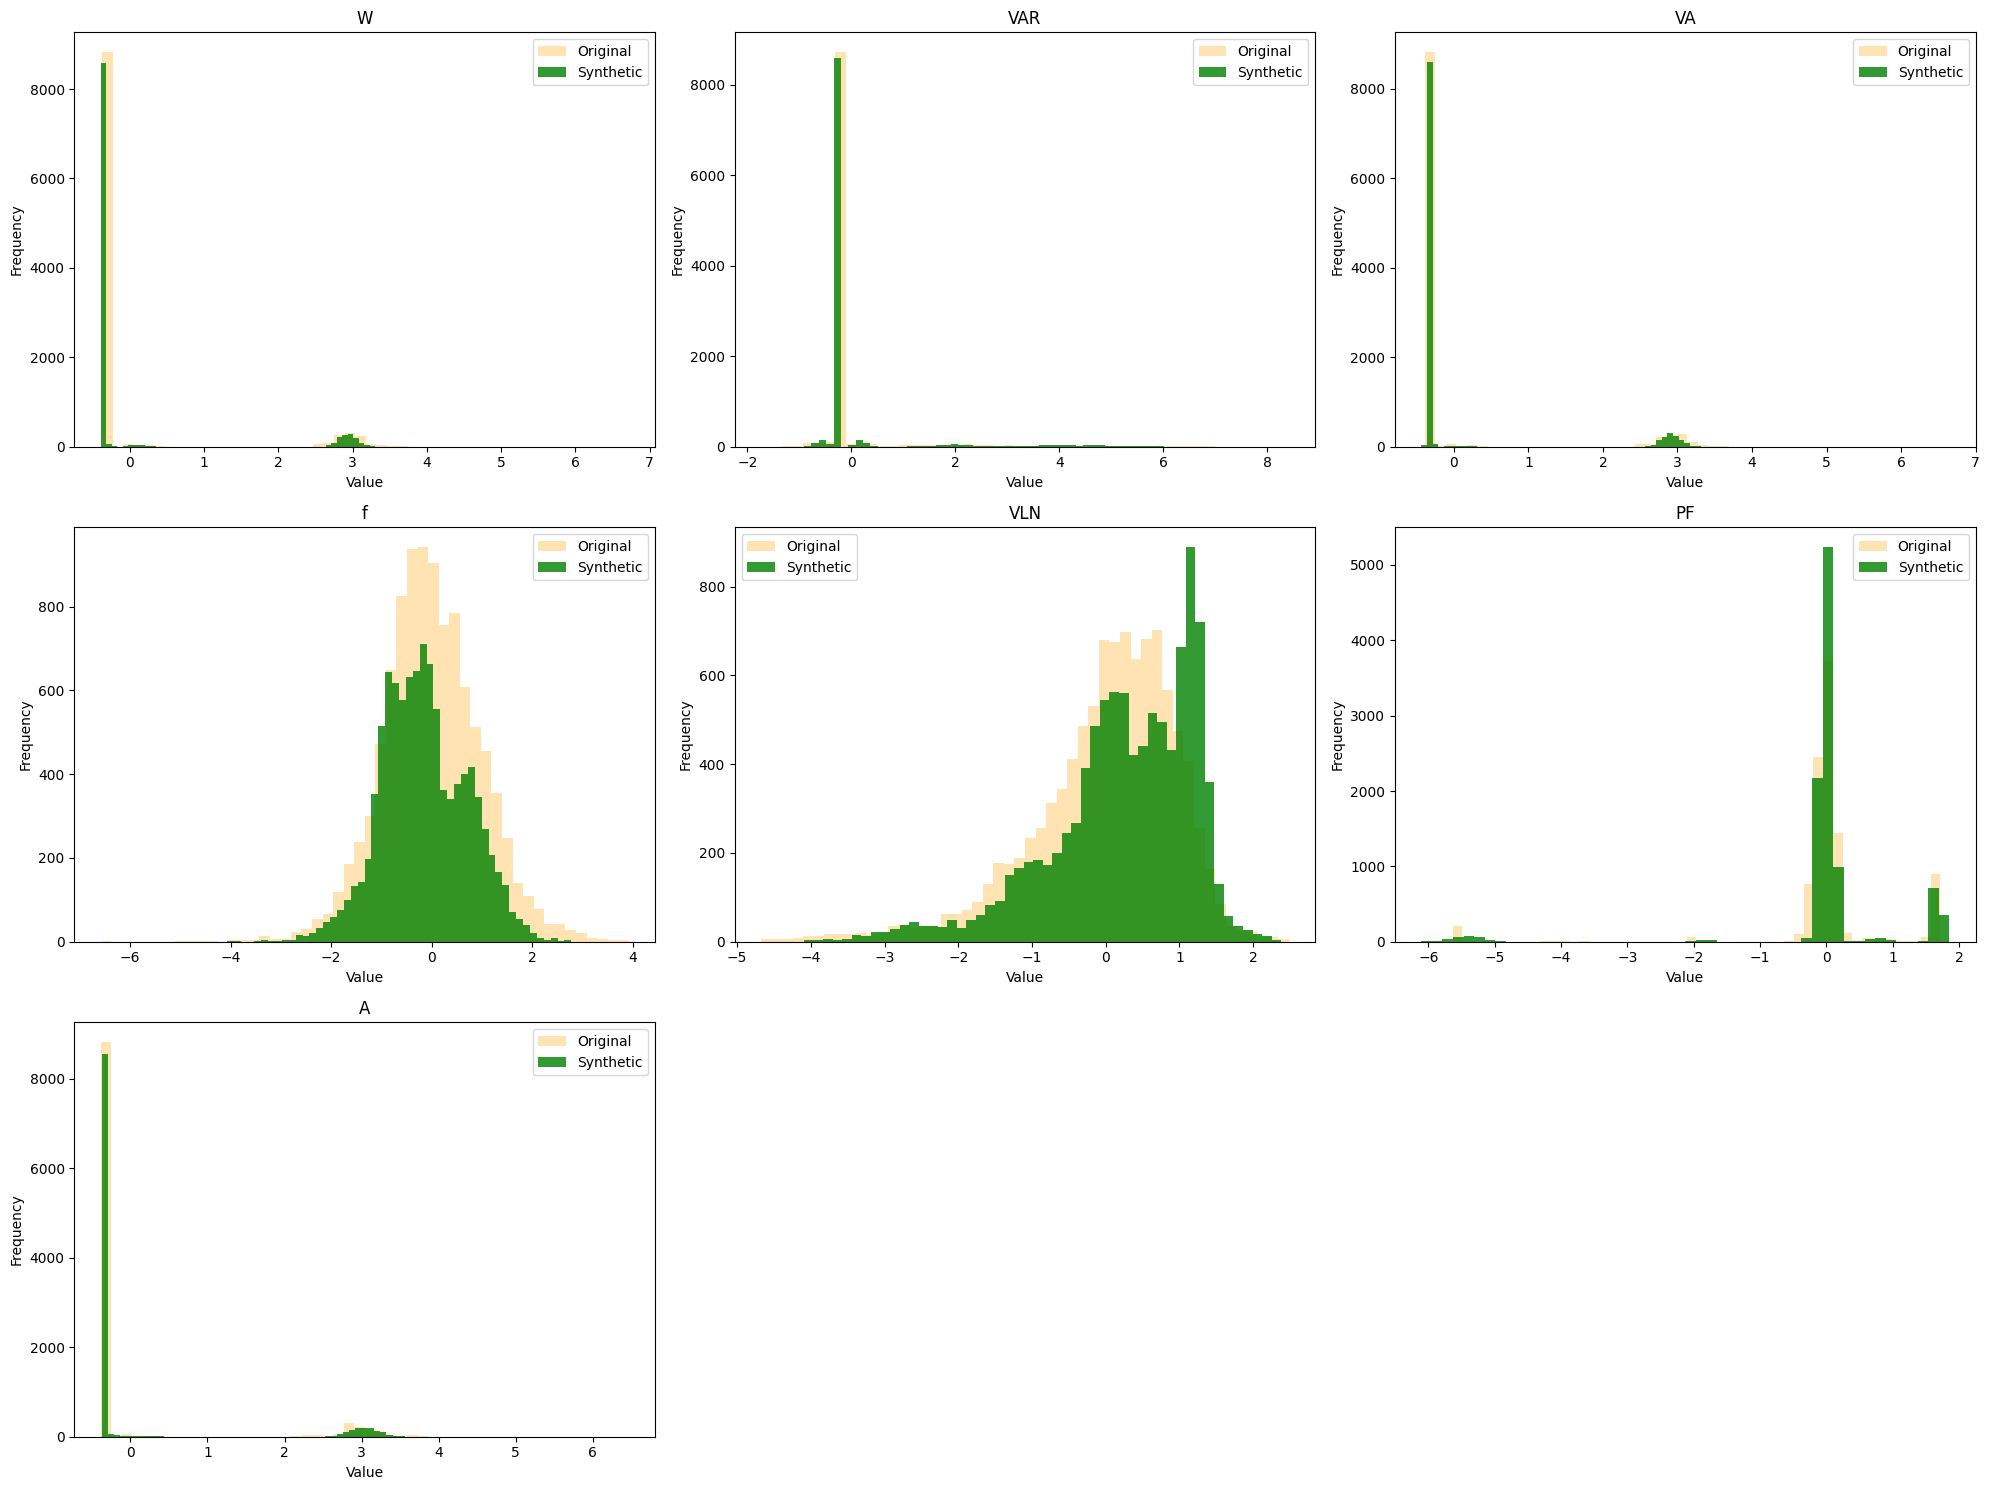

In [94]:
hist_plot(org_df_filtered, synthetic_data)

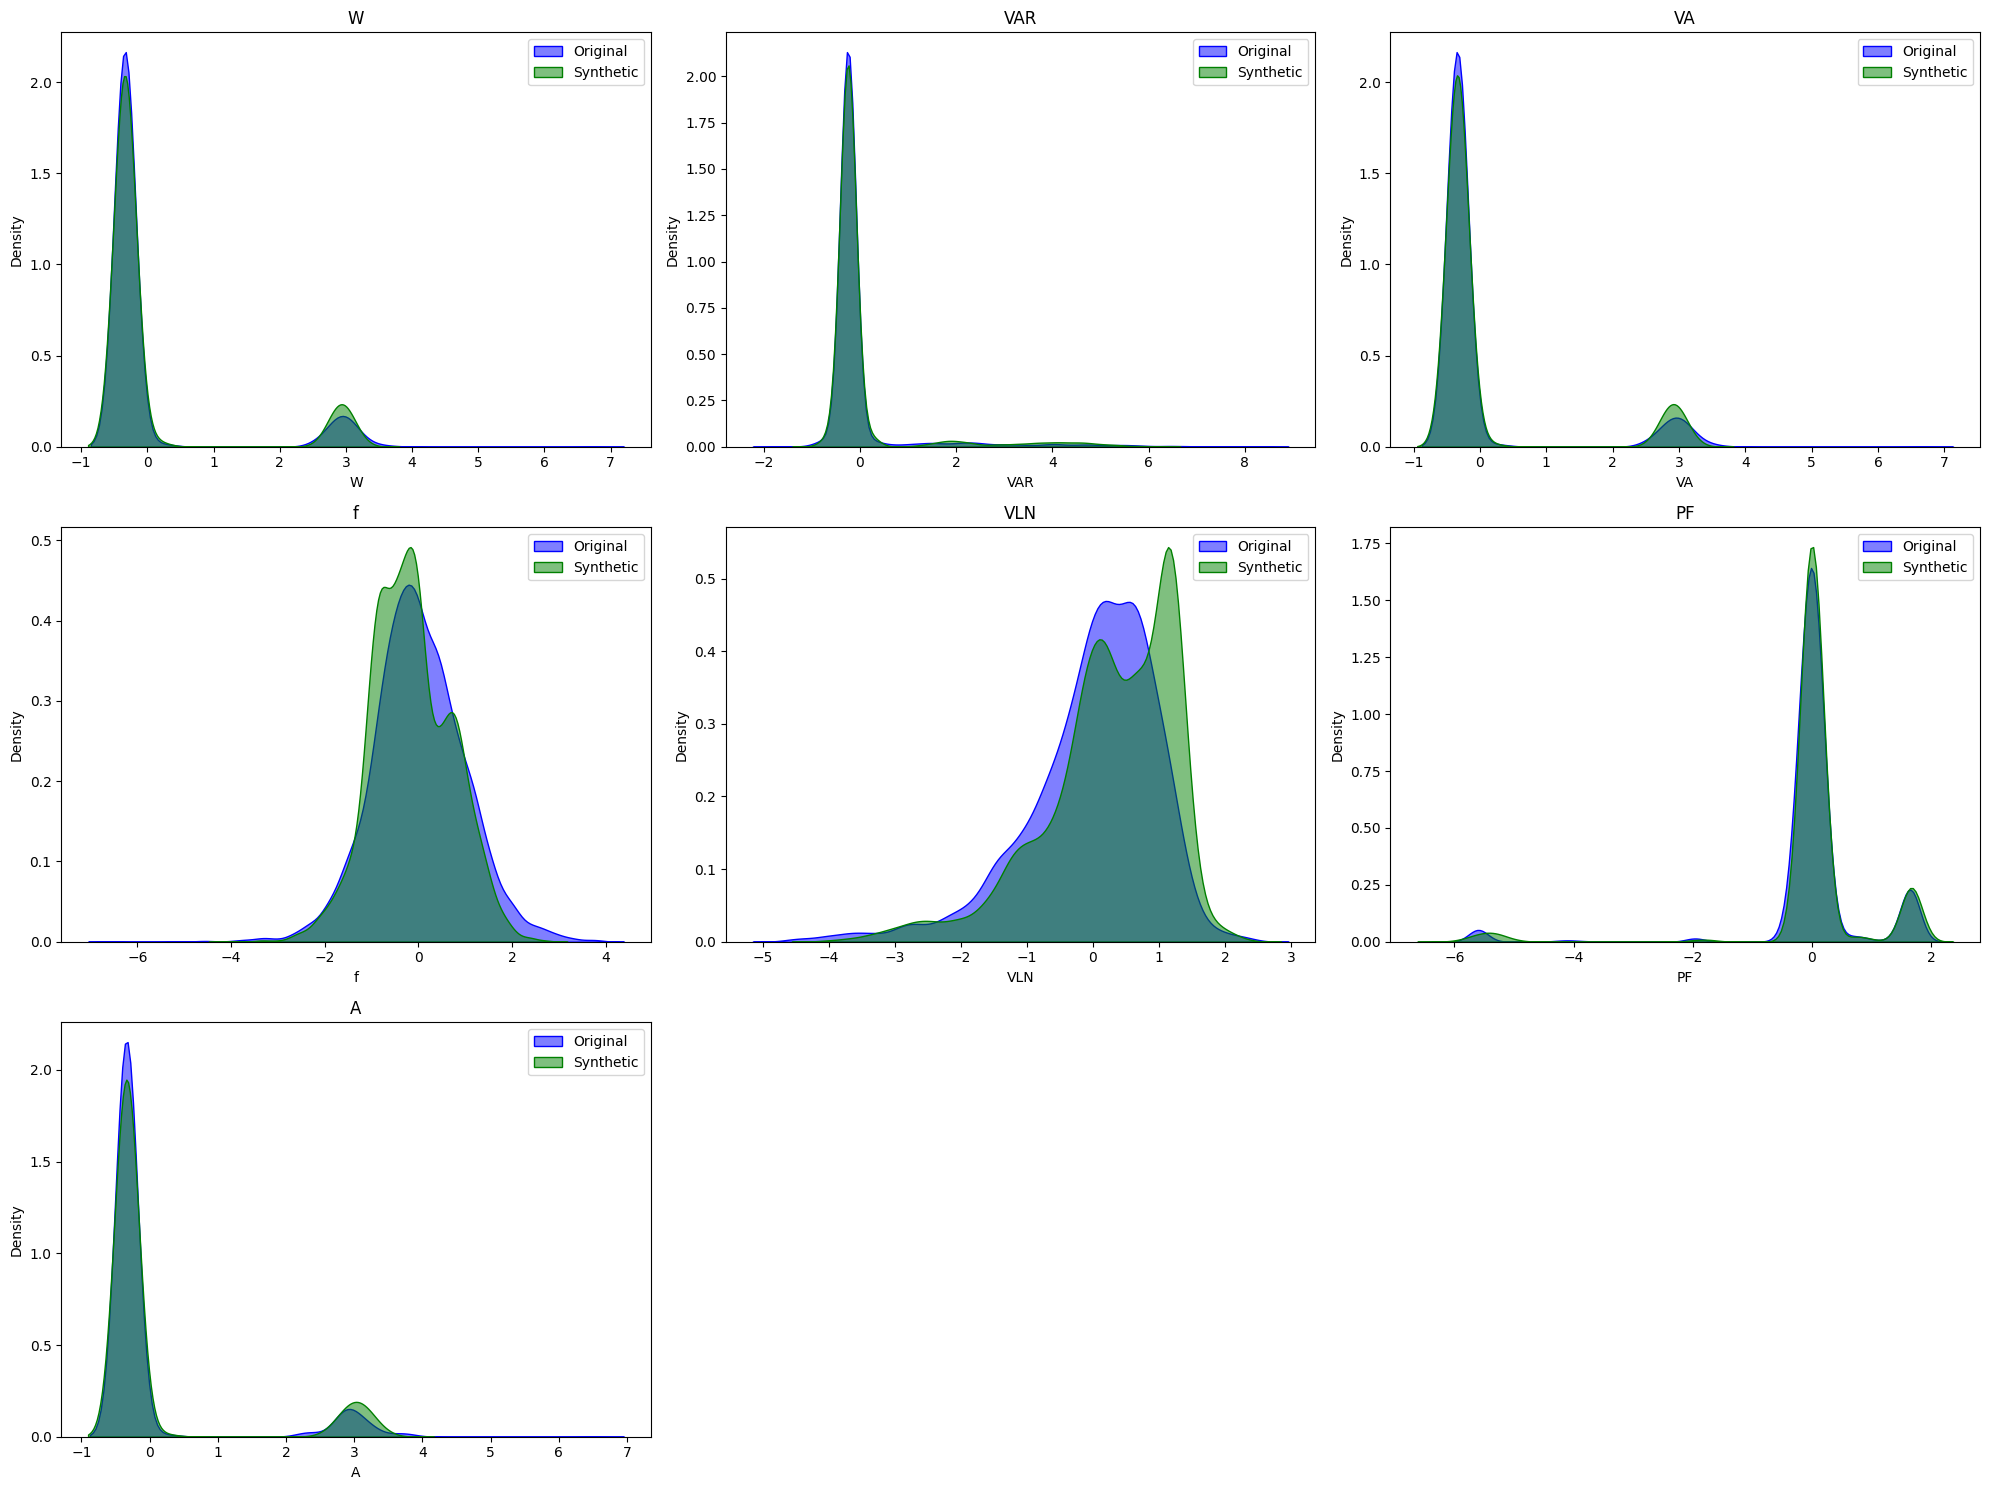

In [95]:
plot_kde(org_df_filtered, synthetic_data)

In [96]:
ks_results = ks_test(org_df_filtered, synthetic_data)
print(ks_results)

  Column  K-S Statistic        p-value
0      W         0.2180  1.781649e-208
1    VAR         0.4589   0.000000e+00
2     VA         0.0946   2.393846e-39
3      f         0.0888   1.026995e-34
4    VLN         0.1623  2.514517e-115
5     PF         0.1144   2.195729e-57
6      A         0.1970  4.537492e-170


In [97]:
chi_square_results = chi_square_test(org_df_filtered, synthetic_data)
print(chi_square_results)

/data/home/jayadeeps/anaconda3/envs/eda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


  Column  Chi-Square Statistic  p-value
0      W                   inf      0.0
1    VAR                   inf      0.0
2     VA                   inf      0.0
3      f                   inf      0.0
4    VLN                   inf      0.0
5     PF                   inf      0.0
6      A                   inf      0.0


In [98]:
summary_statistics = compare_summary_statistics(org_df_filtered, synthetic_data)
summary_statistics

,Column,Original Mean,Synthetic Mean,Original Median,Synthetic Median,Original Std Dev,Synthetic Std Dev,Original Skewness,Synthetic Skewness,Original Kurtosis,Synthetic Kurtosis,Original IQR,Synthetic IQR
0,W,0.016462,0.061796,-0.340940,-0.340030,1.021742,1.068081,2.575343,2.321571,4.767095,3.421795,0.003174,0.009774
1,VAR,0.019209,0.056249,-0.244960,-0.244084,1.031837,1.056498,4.257791,3.560085,18.971449,11.934544,0.000000,0.008563
2,VA,0.016483,0.064368,-0.340514,-0.339532,1.021943,1.069800,2.576631,2.296798,4.772924,3.302621,0.007533,0.010501
3,f,0.000661,-0.152912,-0.044594,-0.201982,0.985429,0.852009,0.014125,0.070006,1.057896,0.025780,1.234608,1.217998
4,VLN,-0.013395,0.236396,0.149848,0.369432,0.997409,0.990089,-1.143882,-1.085434,2.073281,1.328463,1.175239,1.292146
5,PF,0.007644,0.021314,0.010431,0.015161,1.015944,1.090435,-3.439245,-3.302972,18.389251,15.998912,0.216029,0.149028
6,A,0.017837,0.089864,-0.339382,-0.336630,1.026089,1.116196,2.602733,2.269831,4.954723,3.198457,0.006944,0.010784


In [99]:
emd_results = compute_emd(org_df_filtered, synthetic_data)
print(emd_results)

  Column       EMD
0      W  0.057007
1    VAR  0.063317
2     VA  0.061090
3      f  0.181064
4    VLN  0.250448
5     PF  0.070300
6      A  0.078466


In [100]:
def fit_gmm_and_test(org_df, syn_df, n_components=3, ):
    # Fit GMM on the original data
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(org_df)
    
    # Predict cluster labels for original data and synthetic data
    org_labels = gmm.predict(org_df)
    syn_labels = gmm.predict(syn_df)
    
    # Evaluate with Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(org_labels, syn_labels)
    
    # Evaluate clustering on the synthetic data using silhouette score
    sil_score_org = silhouette_score(org_df, org_labels)
    sil_score_syn = silhouette_score(syn_df, syn_labels)
    
    print(f"Adjusted Rand Index (ARI) between original and synthetic data: {ari:.4f}")
    print(f"Silhouette Score for original data: {sil_score_org:.4f}")
    print(f"Silhouette Score for synthetic data: {sil_score_syn:.4f}")
    
    # Predict the log likelihood of synthetic data
    syn_log_likelihood = gmm.score(syn_df)
    print(f"Log Likelihood of synthetic data under GMM: {syn_log_likelihood:.4f}")
    
    return org_labels, syn_labels

def plot_gmm_results(org_df, syn_df, org_labels, syn_labels):
    # Reduce to 2D using PCA for visualization
    pca = PCA(n_components=2)
    org_pca = pca.fit_transform(org_df)
    syn_pca = pca.transform(syn_df)
    
    # Plot original data clusters
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(org_pca[:, 0], org_pca[:, 1], c=org_labels, cmap='viridis', s=50)
    plt.title('Original Data Clusters')
    
    # Plot synthetic data clusters
    plt.subplot(1, 2, 2)
    plt.scatter(syn_pca[:, 0], syn_pca[:, 1], c=syn_labels, cmap='viridis', s=50)
    plt.title('Synthetic Data Clusters')
    
    plt.show()

In [103]:
org_labels, syn_labels = fit_gmm_and_test(org_df_filtered, synthetic_data, n_components=2)

Adjusted Rand Index (ARI) between original and synthetic data: -0.0013
Silhouette Score for original data: 0.6592
Silhouette Score for synthetic data: -0.0960
Log Likelihood of synthetic data under GMM: -2569.7899


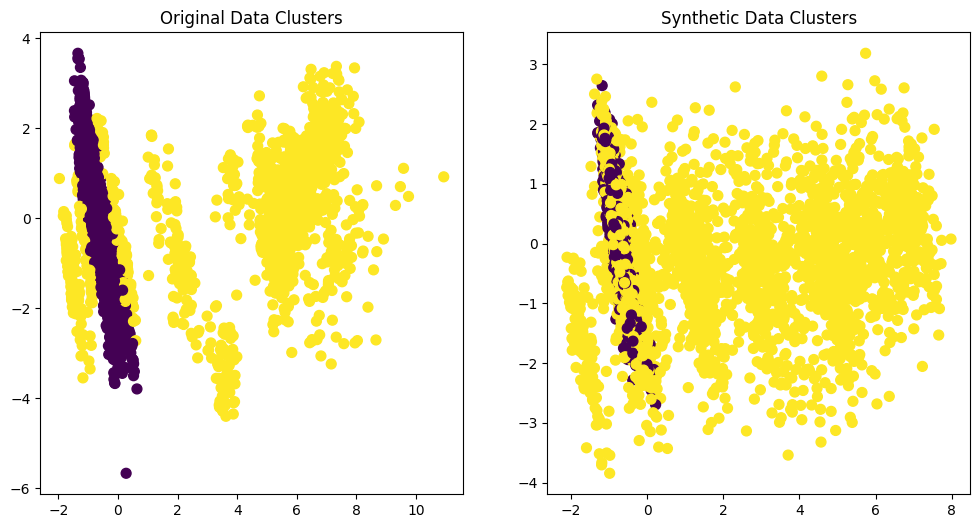

In [104]:
plot_gmm_results(org_df_filtered, synthetic_data, org_labels, syn_labels)

### 6. TVAE Architecture, Training and Inference

In [131]:
class Encoder(Module):

    def __init__(self, data_dim, compress_dims, embedding_dim):
        super(Encoder, self).__init__()
        dim = data_dim
        seq = []
        for item in list(compress_dims):
            seq += [Linear(dim, item), ReLU()]
            dim = item

        self.seq = Sequential(*seq)
        self.fc1 = Linear(dim, embedding_dim)
        self.fc2 = Linear(dim, embedding_dim)

    def forward(self, input_):
        """Encode the passed `input_`."""
        feature = self.seq(input_)
        mu = self.fc1(feature)
        logvar = self.fc2(feature)
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar


class Decoder(Module):
    def __init__(self, embedding_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(decompress_dims):
            seq += [Linear(dim, item), ReLU()]
            dim = item

        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)
        self.sigma = Parameter(torch.ones(data_dim) * 0.1)

    def forward(self, input_):
        """Decode the passed `input_`."""
        return self.seq(input_), self.sigma


def _loss_function(recon_x, x, sigmas, mu, logvar, output_info, factor):
    st = 0
    loss = []
    for column_info in output_info:
        for span_info in column_info:
            if span_info.activation_fn != 'softmax':
                ed = st + span_info.dim
                std = sigmas[st]
                eq = x[:, st] - torch.tanh(recon_x[:, st])
                loss.append((eq**2 / 2 / (std**2)).sum())
                loss.append(torch.log(std) * x.size()[0])
                st = ed

            else:
                ed = st + span_info.dim
                loss.append(
                    cross_entropy(
                        recon_x[:, st:ed], torch.argmax(x[:, st:ed], dim=-1), reduction='sum'
                    )
                )
                st = ed

    assert st == recon_x.size()[1]
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return sum(loss) * factor / x.size()[0], KLD / x.size()[0]


class TVAE(BaseSynthesizer):
    """TVAE."""

    def __init__(
        self,
        embedding_dim=128,
        compress_dims=(128, 128),
        decompress_dims=(128, 128),
        l2scale=1e-5,
        batch_size=500,
        epochs=300,
        loss_factor=2,
        cuda=True,
        verbose=False,
    ):
        self.embedding_dim = embedding_dim
        self.compress_dims = compress_dims
        self.decompress_dims = decompress_dims

        self.l2scale = l2scale
        self.batch_size = batch_size
        self.loss_factor = loss_factor
        self.epochs = epochs
        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        self.verbose = verbose

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

    @random_state
    def fit(self, train_data, discrete_columns=()):
        self.transformer = DataTransformer()
        self.transformer.fit(train_data, discrete_columns)
        train_data = self.transformer.transform(train_data)
        dataset = TensorDataset(torch.from_numpy(train_data.astype('float32')).to(self._device))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)

        data_dim = self.transformer.output_dimensions
        encoder = Encoder(data_dim, self.compress_dims, self.embedding_dim).to(self._device)
        self.decoder = Decoder(self.embedding_dim, self.decompress_dims, data_dim).to(self._device)
        optimizerAE = Adam(
            list(encoder.parameters()) + list(self.decoder.parameters()), weight_decay=self.l2scale
        )

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        iterator = tqdm(range(self.epochs), disable=(not self.verbose))
        if self.verbose:
            iterator_description = 'Loss: {loss:.3f}'
            iterator.set_description(iterator_description.format(loss=0))

        for i in iterator:
            loss_values = []
            batch = []
            for id_, data in enumerate(loader):
                optimizerAE.zero_grad()
                real = data[0].to(self._device)
                mu, std, logvar = encoder(real)
                eps = torch.randn_like(std)
                emb = eps * std + mu
                rec, sigmas = self.decoder(emb)
                loss_1, loss_2 = _loss_function(
                    rec,
                    real,
                    sigmas,
                    mu,
                    logvar,
                    self.transformer.output_info_list,
                    self.loss_factor,
                )
                loss = loss_1 + loss_2
                loss.backward()
                optimizerAE.step()
                self.decoder.sigma.data.clamp_(0.01, 1.0)

                batch.append(id_)
                loss_values.append(loss.detach().cpu().item())

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i] * len(batch),
                'Batch': batch,
                'Loss': loss_values,
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            if self.verbose:
                iterator.set_description(
                    iterator_description.format(loss=loss.detach().cpu().item())
                )

    @random_state
    def sample(self, samples):
        self.decoder.eval()

        steps = samples // self.batch_size + 1
        data = []
        for _ in range(steps):
            mean = torch.zeros(self.batch_size, self.embedding_dim)
            std = mean + 1
            noise = torch.normal(mean=mean, std=std).to(self._device)
            fake, sigmas = self.decoder(noise)
            fake = torch.tanh(fake)
            data.append(fake.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:samples]
        return self.transformer.inverse_transform(data, sigmas.detach().cpu().numpy())

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        self.decoder.to(self._device)

In [132]:
tvae_model = TVAE(
    embedding_dim=128,        
    compress_dims=(128, 128), 
    decompress_dims=(128, 128), 
    l2scale=1e-5,            
    batch_size=500,           
    epochs=300,               
    loss_factor=2,            
    cuda=True,                
    verbose=True             
)

In [ ]:
real_data = pd.read_csv("/data/home/jayadeeps/eda/Datasets/train_data.csv")

In [146]:
num_samples = 10000
train_data = real_data.iloc[:num_samples,:]
discrete_columns = []
tvae_model.fit(train_data, discrete_columns)

11127.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
11127.74s - pydevd: Sending message rela

In [147]:
syn_df = tvae_model.sample(num_samples)

In [135]:
syn_df

,W,VAR,VA,f,VLN,PF,A
0,-0.335854,-0.273506,-0.322292,-0.727506,0.128136,0.188345,-0.321253
1,-0.346538,-0.221788,-0.333023,-0.259319,1.231526,-0.175378,-0.333341
2,-0.350746,-0.299624,-0.340303,0.814717,-0.627598,0.245525,-0.330919
3,-0.343836,-0.305287,-0.348498,-0.303328,-0.472527,-0.113558,-0.342425
4,-0.346147,-0.224375,-0.352475,0.827940,-0.259683,-0.173879,-0.331329
...,...,...,...,...,...,...,...
95,-0.335475,-0.304522,-0.362573,-0.986752,-0.970275,0.264927,-0.342356
96,-0.322240,-0.275275,-0.303866,-0.567781,-0.076696,-0.120974,-0.335857
97,-0.333415,-0.266205,-0.344844,0.294021,0.740649,-0.143471,-0.330356
98,-0.344410,-0.262833,-0.319887,-0.001477,0.708633,0.013934,-0.323139


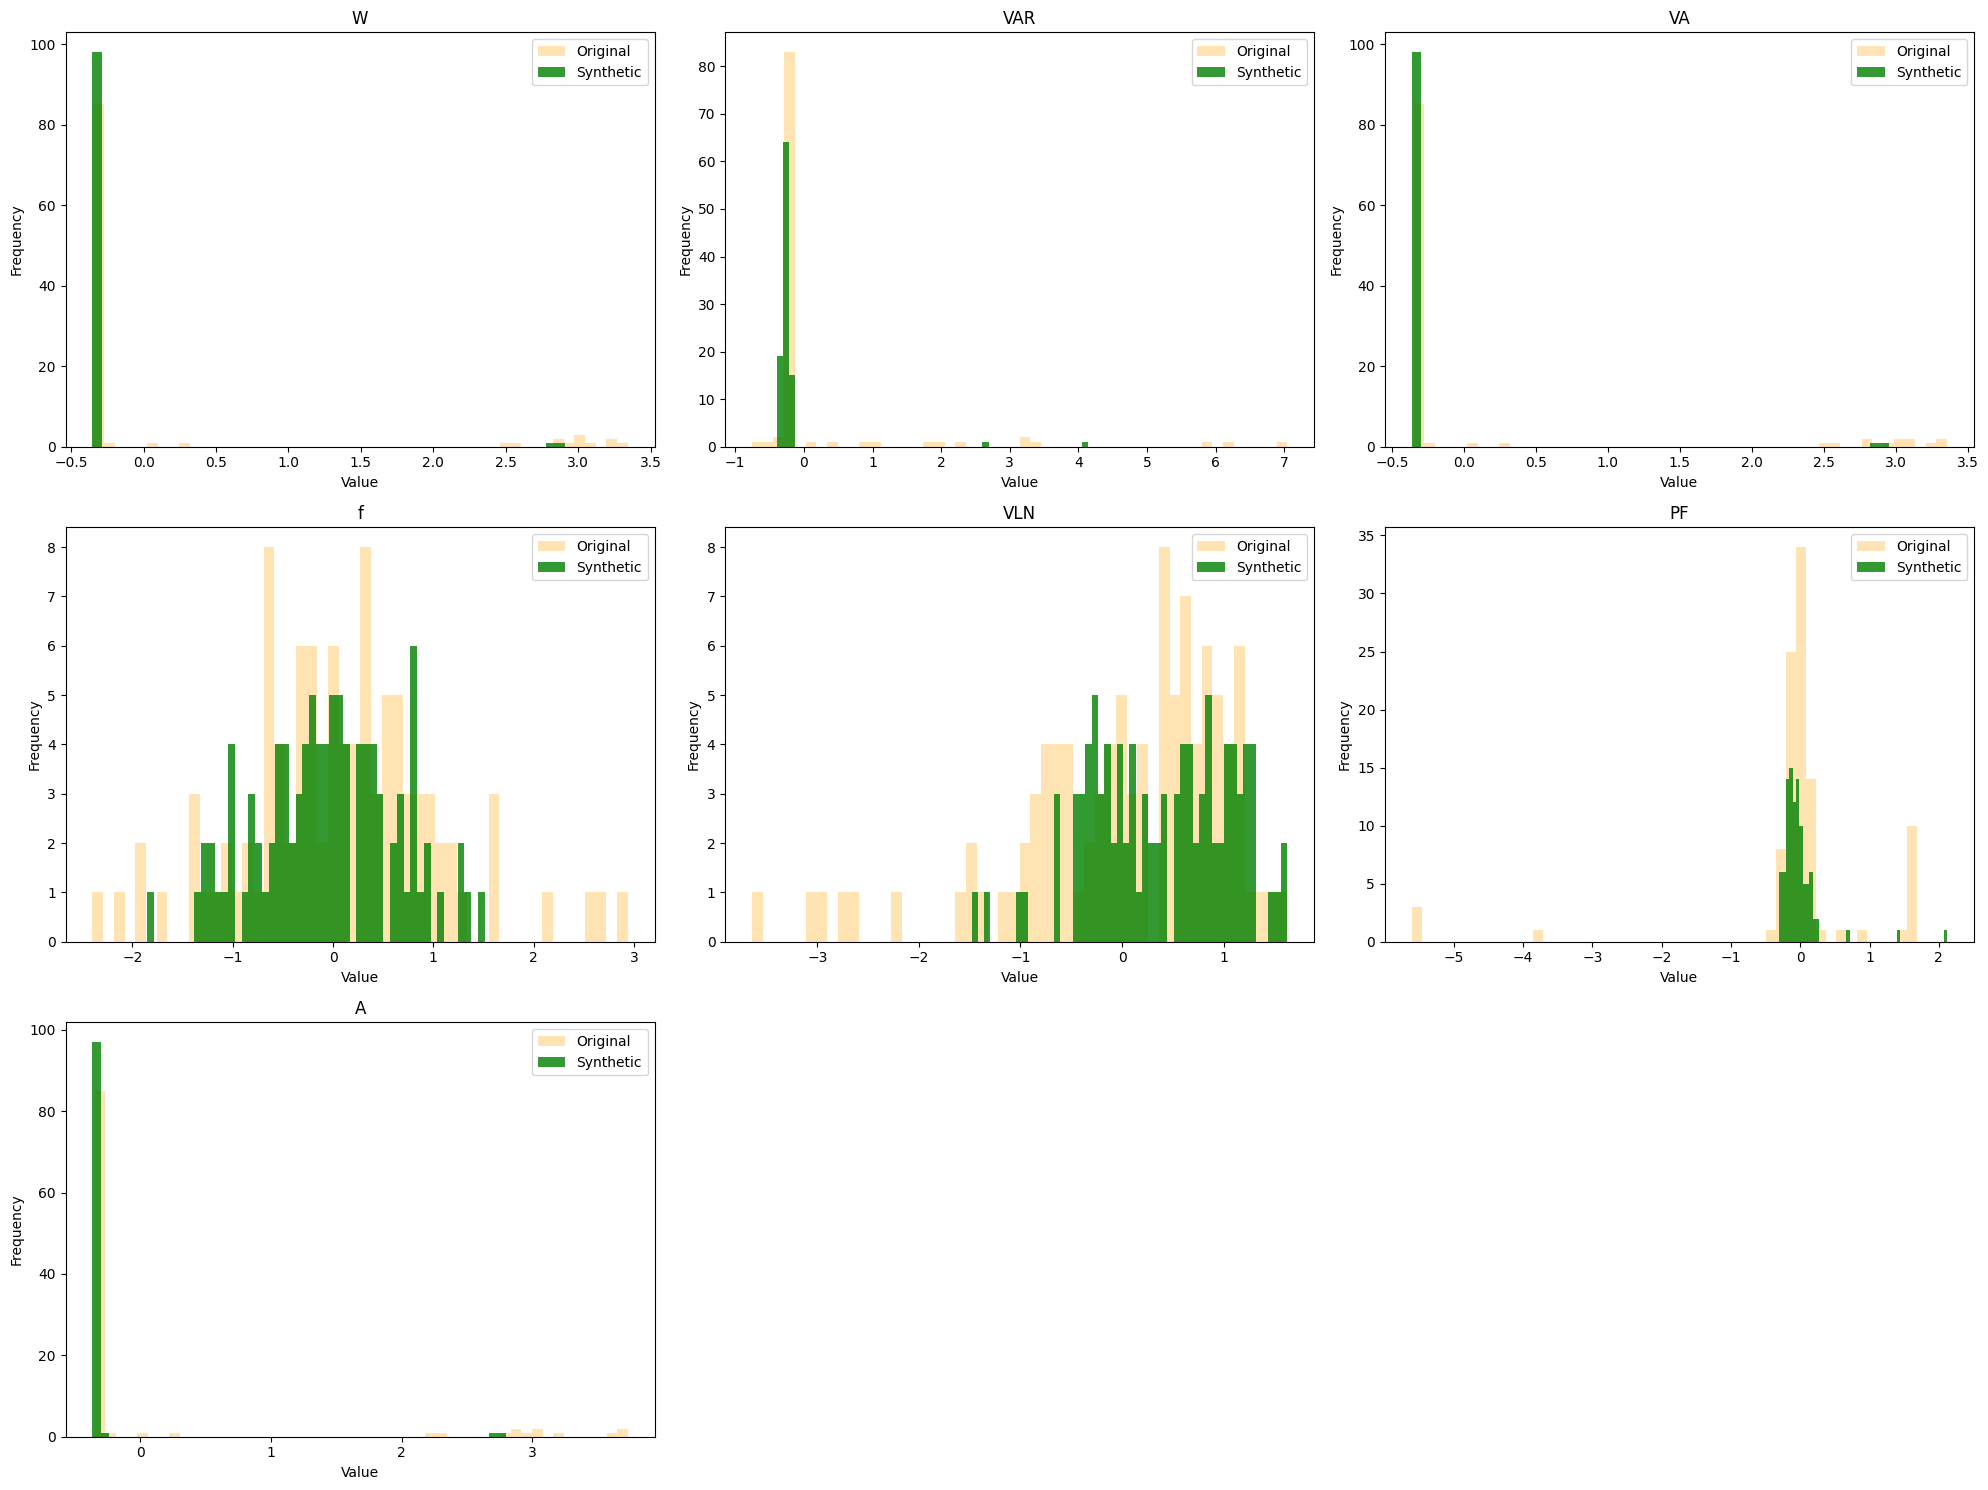

In [136]:
hist_plot(train_data, syn_df)

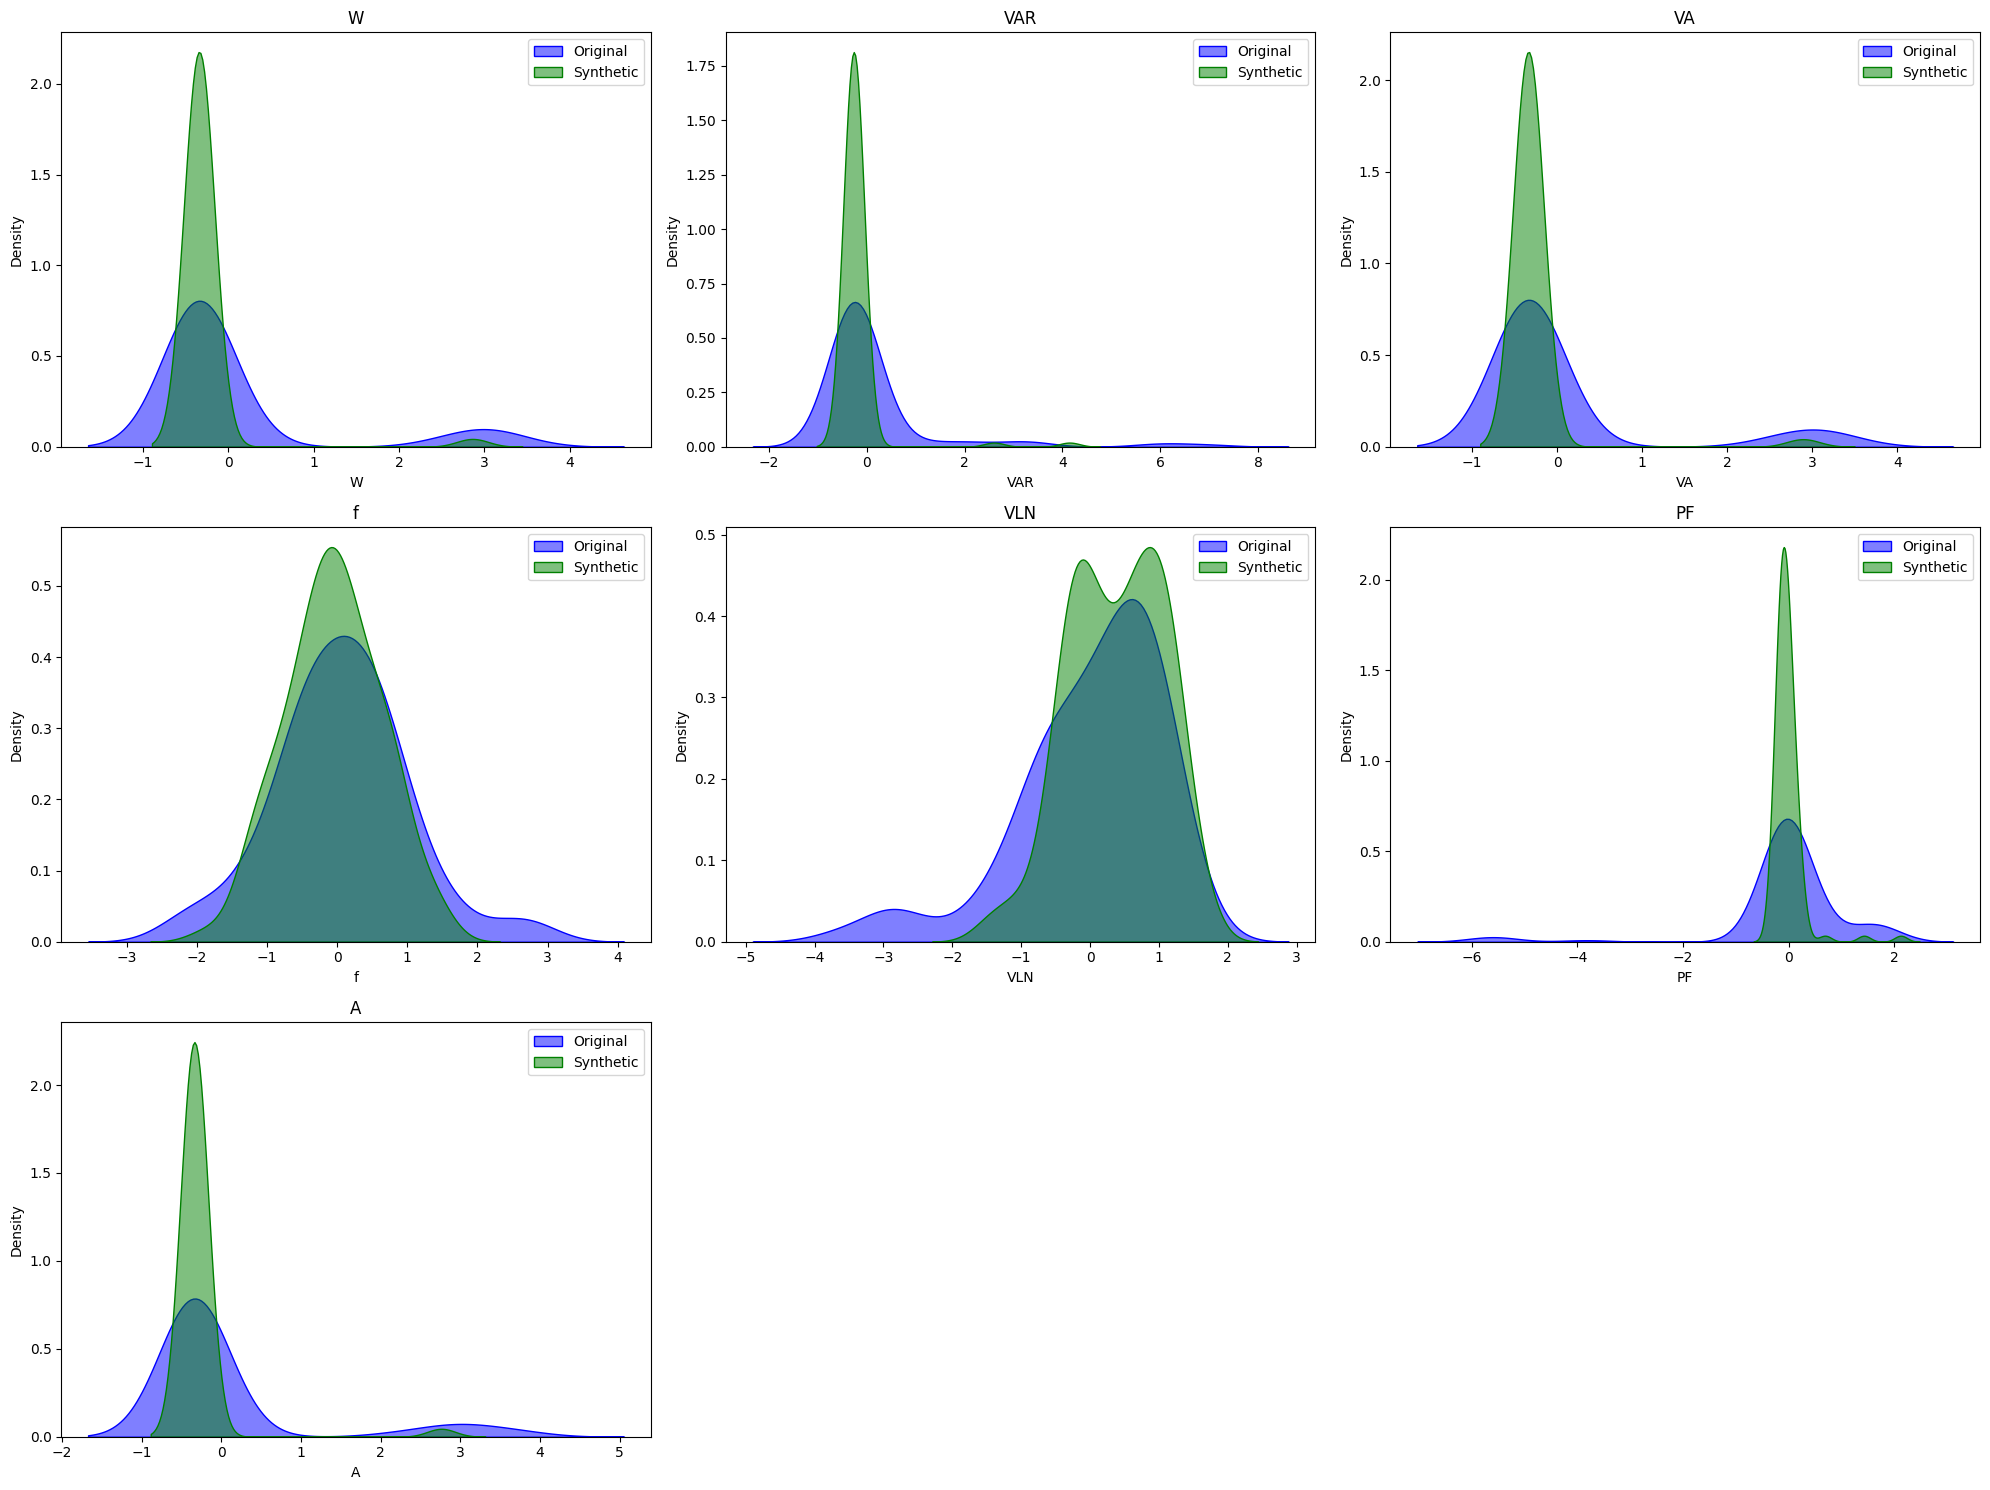

In [137]:
plot_kde(train_data, syn_df)

In [138]:
ks_results = ks_test(train_data, syn_df)
print(ks_results)

  Column  K-S Statistic       p-value
0      W           0.26  2.219936e-03
1    VAR           0.59  1.767145e-16
2     VA           0.28  7.377026e-04
3      f           0.12  4.695064e-01
4    VLN           0.22  1.557713e-02
5     PF           0.25  3.729492e-03
6      A           0.29  4.117410e-04


In [141]:
chi_square_results = chi_square_test(train_data, syn_df)
print(chi_square_results)

  Column  Chi-Square Statistic  p-value
0      W                   inf      0.0
1    VAR                   inf      0.0
2     VA                   inf      0.0
3      f                   inf      0.0
4    VLN                   inf      0.0
5     PF                   inf      0.0
6      A                   inf      0.0


/data/home/jayadeeps/anaconda3/envs/eda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [142]:
summary_statistics = compare_summary_statistics(train_data, syn_df)
summary_statistics

,Column,Original Mean,Synthetic Mean,Original Median,Synthetic Median,Original Std Dev,Synthetic Std Dev,Original Skewness,Synthetic Skewness,Original Kurtosis,Synthetic Kurtosis,Original IQR,Synthetic IQR
0,W,0.068140,-0.274569,-0.340967,-0.339858,1.082919,0.450600,2.344579,6.855931,3.579509,45.032927,0.003700,0.009890
1,VAR,0.150203,-0.194676,-0.244960,-0.262187,1.323771,0.526211,3.709137,7.207790,13.746691,52.306519,0.000000,0.068451
2,VA,0.070332,-0.274099,-0.339743,-0.339219,1.087328,0.454627,2.350422,6.853814,3.618160,45.034345,0.006333,0.015484
3,f,0.060880,-0.053378,0.052227,-0.061736,0.963881,0.679583,0.213191,-0.043726,0.819858,-0.336997,1.146330,0.875540
4,VLN,0.015116,0.371827,0.224540,0.402625,1.051975,0.679922,-1.243939,-0.286524,1.633334,-0.548151,1.344249,1.083649
5,PF,-0.040353,-0.023273,0.006770,-0.075444,1.189375,0.301681,-3.114431,4.840285,13.043016,28.753286,0.195996,0.178536
6,A,0.075805,-0.275030,-0.339039,-0.335352,1.110663,0.436457,2.420446,6.849722,4.074044,44.965522,0.006433,0.016664


In [143]:
emd_results = compute_emd(train_data, syn_df)
print(emd_results)

  Column       EMD
0      W  0.344868
1    VAR  0.364328
2     VA  0.346178
3      f  0.212717
4    VLN  0.356712
5     PF  0.387290
6      A  0.354782


In [ ]:
def fit_gmm_and_test(org_df, syn_df, n_components=3, ):
    # Fit GMM on the original data
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(org_df)
    
    # Predict cluster labels for original data and synthetic data
    org_labels = gmm.predict(org_df)
    syn_labels = gmm.predict(syn_df)
    
    # Evaluate with Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(org_labels, syn_labels)
    
    # Evaluate clustering on the synthetic data using silhouette score
    sil_score_org = silhouette_score(org_df, org_labels)
    sil_score_syn = silhouette_score(syn_df, syn_labels)
    
    print(f"Adjusted Rand Index (ARI) between original and synthetic data: {ari:.4f}")
    print(f"Silhouette Score for original data: {sil_score_org:.4f}")
    print(f"Silhouette Score for synthetic data: {sil_score_syn:.4f}")
    
    # Predict the log likelihood of synthetic data
    syn_log_likelihood = gmm.score(syn_df)
    print(f"Log Likelihood of synthetic data under GMM: {syn_log_likelihood:.4f}")
    
    return org_labels, syn_labels

def plot_gmm_results(org_df, syn_df, org_labels, syn_labels):
    # Reduce to 2D using PCA for visualization
    pca = PCA(n_components=2)
    org_pca = pca.fit_transform(org_df)
    syn_pca = pca.transform(syn_df)
    
    # Plot original data clusters
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(org_pca[:, 0], org_pca[:, 1], c=org_labels, cmap='viridis', s=50)
    plt.title('Original Data Clusters')
    
    # Plot synthetic data clusters
    plt.subplot(1, 2, 2)
    plt.scatter(syn_pca[:, 0], syn_pca[:, 1], c=syn_labels, cmap='viridis', s=50)
    plt.title('Synthetic Data Clusters')
    
    plt.show()

In [148]:
org_labels, syn_labels = fit_gmm_and_test(train_data, syn_df, n_components=2)

Adjusted Rand Index (ARI) between original and synthetic data: -0.0051
Silhouette Score for original data: 0.6566
Silhouette Score for synthetic data: 0.6074
Log Likelihood of synthetic data under GMM: -161.3369


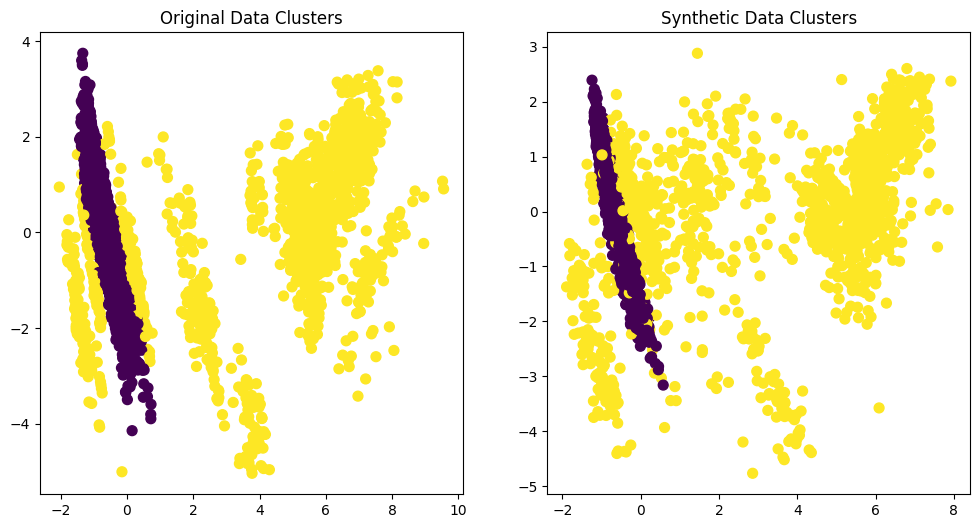

In [149]:
plot_gmm_results(train_data, syn_df, org_labels, syn_labels)

#### References:
1) https://github.com/sdv-dev/CTGAN/blob/main/ctgan/synthesizers/ctgan.py